In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import os
import pathlib
import pandas as pd
import numpy as np
import re
import upsetplot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from proteobench.modules.quant.quant_lfq_ion_DDA_QExactive import DDAQuantIonModuleQExactive
from proteobench.io.params.fragger import extract_params as extract_fragpipe_params
from proteobench.io.params.i2masschroq import extract_params as extract_i2masschroq_params
from proteobench.io.params.maxquant import extract_params as extract_maxquant_params
from proteobench.io.params.sage import extract_params as extract_sage_params
from proteobench.io.params.alphapept import extract_params as extract_alphapept_params
from proteobench.io.params.proline import extract_params as extract_proline_params
from proteobench.io.params.wombat import extract_params as extract_wombat_params
from proteobench.io.params.msangel import extract_params as extract_msangel_params
from proteobench.io.params.quantms import extract_params as extract_quantms_params
from proteobench.io.params.peaks import extract_params as extract_peaks_params
from proteobench.datapoint.quant_datapoint import (
    filter_df_numquant_epsilon,
    filter_df_numquant_nr_prec,
)
from proteobench.plotting.plot_quant import PlotDataPoint
from plotly.subplots import make_subplots
from proteobench.utils.server_io import get_merged_json, get_raw_data

from matplotlib.colors import to_rgba

In [2]:
MAPPERS = {
    "FragPipe": {
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "FragPipeMBR": {
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "PEAKS": {
        "Sample 1 Normalized Area": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "Sample 2 Normalized Area": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "Sample 3 Normalized Area": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "Sample 4 Normalized Area": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "Sample 5 Normalized Area": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "Sample 6 Normalized Area": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "MSAngel": {
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "ProlineStudio": {
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.mgf": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02.mgf": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03.mgf": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01.mgf": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02.mgf": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03.mgf": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    }
}

# Download the data

In [3]:
# QExactive
QExactive_df = get_merged_json(
    repo_url="https://github.com/Proteobench/Results_quant_ion_DDA/archive/refs/heads/main.zip",
    outfile_name="astral_df.json",
    write_to_file=True,
)
hash_dict_qexactive = get_raw_data(df=QExactive_df)

Combined 49 JSON files into 'combined_results.json'.
Folder already exists and is not empty, skipping download: extracted_files/00e2f863939301a2a71178652972dad895b27520
Folder already exists and is not empty, skipping download: extracted_files/0280a06fabdbe84746419d0810deae56e7ab2406
Folder already exists and is not empty, skipping download: extracted_files/1438823a0441d7a32c0d1095074cbc4a187ce2fb
Folder already exists and is not empty, skipping download: extracted_files/1bfa914c771321b285a9ca40d4aa538cb9fdc42e
Folder already exists and is not empty, skipping download: extracted_files/254d6c77ce656888918e738772ad5f5f6f1543e4
Folder already exists and is not empty, skipping download: extracted_files/2805f6b6d1fabd65448540bee743f2b05c1dda59
Folder already exists and is not empty, skipping download: extracted_files/28b0c3b9853a5b60c9e47428b8a51b4898083523
Folder already exists and is not empty, skipping download: extracted_files/2a5ef6191b8098757d490acf76bb9c2af5b89a39
Folder already exis

In [4]:
QExactive_df

,old_new,id,software_name,software_version,search_engine,search_engine_version,ident_fdr_psm,ident_fdr_peptide,ident_fdr_protein,enable_match_between_runs,...,results.2.CV_q95,results.1.median_abs_epsilon,results.1.mean_abs_epsilon,results.1.variance_epsilon,results.1.nr_prec,results.1.CV_median,results.1.CV_q90,results.1.CV_q75,results.1.CV_q95,semi_enzymatic
0,new,FragPipe_20250610_105602,FragPipe,22.0,MSFragger,None,0.01,0.01,0.01,True,...,0.788035,0.262164,0.468786,0.594224,66868,0.175963,0.587762,0.333746,0.788035,NaN
1,new,WOMBAT_20250610_110830,WOMBAT,0.9.11,various,nan,0.01,0.01,0.01,True,...,0.607294,0.212302,0.329306,0.283674,47947,0.219061,0.485912,0.322314,0.607294,NaN
2,new,i2MassChroQ_20250610_113133,i2MassChroQ,1.0.18,Sage,0.14.7,0.005999419143,0.008561447245,0.009234643907,True,...,0.642148,0.216986,0.357800,0.305466,73380,0.130935,0.496430,0.281160,0.642148,NaN
3,new,MaxQuant_20250610_104137,MaxQuant,2.3.1.0,Andromeda,nan,0.01,None,0.01,True,...,0.569765,0.207123,0.304261,0.222469,50339,0.215507,0.460770,0.312472,0.569765,NaN
4,new,FragPipe_20250605_125705,FragPipe,22.1-build02,MSFragger,None,0.01,0.01,0.01,True,...,0.858434,0.286891,0.540897,0.796221,53587,0.250876,0.653933,0.384580,0.858434,NaN
5,new,i2MassChroQ_20250610_105416,i2MassChroQ,1.2.0,Sage,0.15.0-alpha,0.0099991764759,0.0141726898633,0.00948714423209,False,...,0.612720,0.202517,0.324796,0.251562,72272,0.120766,0.477308,0.264119,0.612720,NaN
6,new,MaxQuant_20250610_112438,MaxQuant,1.5.2.8,Andromeda,nan,0.01,None,0.01,False,...,0.524623,0.202356,0.278361,0.162885,51193,0.204522,0.426579,0.295455,0.524623,NaN
7,new,WOMBAT_20250605_083310,WOMBAT,0.9.11,various,nan,0.01,0.01,0.01,True,...,0.709905,0.210835,0.358603,0.347533,56979,0.235001,0.547399,0.352267,0.709905,NaN
8,new,MaxQuant_20250610_104638,MaxQuant,1.5.8.2,Andromeda,nan,0.01,None,0.01,True,...,0.597572,0.209998,0.324032,0.276706,49679,0.217079,0.475874,0.317542,0.597572,NaN
9,new,i2MassChroQ_20250610_104346,i2MassChroQ,1.0.16,X! Tandem,X! Tandem Alanine (2017.2.1.4),0.008998493465,0.01196294798,0.009873268494,False,...,0.613680,0.211233,0.329852,0.255909,77949,0.130385,0.477048,0.269583,0.613680,NaN


# Functions

In [5]:
def extract_all_from_hashes(
    hashes, data_dir="extracted_files", module=DDAQuantIonModuleQExactive(token="")
):
    """Extract all results from hashes."""
    all_datapoints = pd.DataFrame()
    results_dict = {}
    comments = []

    for point_hash, tool in hashes.items():
        print(f"Processing {point_hash} - {tool}")
        if not tool in results_dict:
            results_dict[tool] = {}

        raw_data_path = f"{data_dir}/{point_hash}/input_file"  # Extension can vary
        param_path = f"{data_dir}/{point_hash}/param_"  # Extension and number can vary

        # Identify the correct raw data file extension. There can be only one raw data file per point_hash.
        raw_data_files = list(
            pathlib.Path(raw_data_path).parent.glob(
                f"{pathlib.Path(raw_data_path).name}.*"
            )
        )
        print(f"Raw data files found: {raw_data_files}")
        # Identify the correct parameter file extension. There can be one or two (quantms) parameter files per point_hash.
        param_files = list(
            pathlib.Path(param_path).parent.glob(f"{pathlib.Path(param_path).name}*.*")
        )
        print(f"Parameter files found: {param_files}")

        if not raw_data_files or not param_files:
            print(
                f"Skipping {point_hash} - {tool}: No raw data or parameter files found."
            )
            continue
        raw_data_path = raw_data_files[0]

        extract_params_func = globals()[
            f"extract_{tool.replace('-', '').lower().replace(' (diann quant)', '').replace('prolinestudio', 'proline')}_params"
        ]

        if "quantms" in tool:
            param_data = extract_params_func(file1 = open(param_files[0], "rb"), file2 = open(param_files[1], "rb")).__dict__
        elif "FragPipe" in tool or "AlphaPept" in tool:
            param_data = extract_params_func(open(param_files[0], "rb")).__dict__
        else:
            param_data = extract_params_func(param_files[0]).__dict__

        results_performance, all_datapoints, _ = module.benchmarking(
            raw_data_path, tool, user_input=param_data, all_datapoints=all_datapoints
        )

        if "MaxQuant" in tool:
            print("adding carbamidos to maxquant")
            results_performance["precursor ion"] = results_performance[
                "precursor ion"
            ].apply(lambda x: x.replace("C", "C[Carbamidomethyl]"))

        if "PEAKS" in tool or "i2MassChroQ" in tool:
            print("rewriting N-Terminal acetylation")
            results_performance["precursor ion"] = results_performance[
                "precursor ion"
            ].apply(rewrite_nterm_acetylation)

        results_dict[tool][point_hash] = results_performance
        # overwrite new hash with actual hash
        all_datapoints.loc[all_datapoints["old_new"] == 'new', "intermediate_hash"] = point_hash
        print(all_datapoints["intermediate_hash"])
    # Set all datapoints to old
    all_datapoints["old_new"] = "old"
    return results_dict, all_datapoints

def rewrite_nterm_acetylation(proforma):
    # A[Acetyl]AAAAAAGDSDSWDADAFSVEDPVRK -> [Acetyl]-AAAAAAAGDSDSWDADAFSVEDPVRK
    if proforma[1:9] == "[Acetyl]":
        return f"[Acetyl]-{proforma[0] + proforma[9:]}"
    return proforma

In [6]:
def prepare_datapoints(all_datapoints, min_quant=3):
    """Filter and calculate metrics for data points."""
    all_datapoints["median_abs_epsilon"] = [
        filter_df_numquant_epsilon(v, min_quant=min_quant)
        for v in all_datapoints["results"]
    ]
    all_datapoints["nr_prec"] = [
        filter_df_numquant_nr_prec(v, min_quant=min_quant)
        for v in all_datapoints["results"]
    ]
    return all_datapoints


def plot_performance_metrics(
    all_datapoints,
    min_quant=3,
    metric="Median",
    subset=None,
    x_range=None,
    y_range=None,
    autoscale=True,
    subset_col="id",
):
    """Plot performance metrics for data points."""
    if subset:
        all_datapoints = all_datapoints[all_datapoints[subset_col].isin(subset)]
    all_datapoints = prepare_datapoints(all_datapoints, min_quant=min_quant)

    print(all_datapoints)
    print(metric)
    plot = PlotDataPoint.plot_metric(
        all_datapoints,
        metric=metric,
        hide_annot=True,
    )
    plot.update_layout(
        xaxis=dict(range=x_range) if x_range else {},
        yaxis=dict(range=y_range) if y_range else {},
    )

    if autoscale:
        # Automatically adjust the y-axis range based on the data
        y_min = all_datapoints["nr_prec"].min()
        y_max = all_datapoints["nr_prec"].max()
        plot.update_yaxes(range=[y_min-(y_min*0.08), y_max+(y_max*0.05)])

        if metric == "Median":
            x_min = all_datapoints["median_abs_epsilon"].min()
            x_max = all_datapoints["median_abs_epsilon"].max()
        else:
            x_min = all_datapoints["mean_abs_epsilon"].min()
            x_max = all_datapoints["mean_abs_epsilon"].max()
        plot.update_xaxes(range=[x_min-(x_min*0.05), x_max+(x_max*0.05)])

    # update x axis and y axis label
    plot.update_xaxes(title_text="{}QuantError({})".format(metric, min_quant))
    plot.update_yaxes(title_text="Depth({})".format(min_quant))

    return plot


def plot_performance_metrics_all_filters(
    all_datapoints,
    metric="Median",
    subset=None,
    subset_col="id",
):

    if subset:
        all_datapoints = all_datapoints[all_datapoints[subset_col].isin(subset)]

    plots = []
    x_min = 0
    x_max = 0
    y_min = 0
    y_max = 0

    for min_quant in range(1, 7):
        datapoints = prepare_datapoints(all_datapoints, min_quant=min_quant)
        plot = PlotDataPoint.plot_metric(datapoints, metric=metric, hide_annot=True)
        plots.append(plot)

        print(datapoints["median_abs_epsilon"].min())
        print(datapoints["median_abs_epsilon"].max())

        if datapoints["median_abs_epsilon"].min() < x_min or x_min == 0:
            x_min = datapoints["median_abs_epsilon"].min()
        if datapoints["median_abs_epsilon"].max() > x_max or x_max == 0:
            x_max = datapoints["median_abs_epsilon"].max()
        if datapoints["nr_prec"].min() < y_min or y_min == 0:
            y_min = datapoints["nr_prec"].min()
        if datapoints["nr_prec"].max() > y_max or y_max == 0:
            y_max = datapoints["nr_prec"].max()

    combined_fig = make_subplots(
        rows=2,
        cols=3,
        subplot_titles=[f"k={i}" for i in range(1, 7)]
    )

    positions = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]

    y_min_scaled = y_min - (y_min * 0.3)
    y_max_scaled = y_max + (y_max * 0.05)

    x_min_scaled = x_min - (x_min * 0.05)
    x_max_scaled = x_max + (x_max * 0.3)

    print(f"x_min: {x_min}, x_max: {x_max}"
          f"y_min: {y_min}, y_max: {y_max}")

    for fig, (r, c) in zip(plots, positions):
        for trace in fig.data:
            combined_fig.add_trace(trace, row=r, col=c)
    combined_fig.update_layout(height=800, width=1200)

    layout_update = {}
    for i in range(1, 7+1):  # N = number of subplots
        layout_update[f"xaxis{i if i>1 else ''}"] = dict(range=[0.1, 0.6])
        layout_update[f"yaxis{i if i>1 else ''}"] = dict(range=[y_min_scaled, y_max_scaled])

    combined_fig.update_layout(**layout_update)

    # remove duplicate legend items
    names = set()
    combined_fig.for_each_trace(
        lambda trace: (
            trace.update(showlegend=False)
            if (trace.name in names)
            else names.add(trace.name)
        )
    )

    return combined_fig


def prepare_performance_dict(results, mappers=MAPPERS, mapper=None, subset=None):
    """Prepare a dictionary of performance results."""
    if subset:
        results = {
            k: {sk: v for sk, v in inner_dict.items() if sk in subset}
            for k, inner_dict in results.items()
        }
    #print(results)

    performance_dict = {}
    for tool, subdict in results.items():
        print(f"Processing {tool}")
        print(f"Tool has the following runs: {subdict.keys()}")
        for run_name, df in subdict.items():
            print(f"Processing {run_name}")
            if mapper != None:
                df = df.rename(columns=mappers[mapper])
            elif tool in mappers:
                tool_mapper = mappers[tool]
                df = df.rename(columns=tool_mapper)

            df.columns = [x.replace(".mzML", "") for x in df.columns]
            if tool not in performance_dict:
                performance_dict[tool] = []
            performance_dict[tool].append(df)
    return performance_dict



In [7]:
def filter_upset_data(data, tools):
    # Filter the data so that only subsets are plotted that contain sequences from all tools, from all-but-one tool, or from only one tool
    data_index_reset = data.reset_index()
    ids = data_index_reset["id"]
    occurrences = data_index_reset.drop(columns="id")
    occurrences = occurrences.astype(int)
    row_sums = occurrences.sum(axis=1)
    # Turn row_sums into a dataframe
    row_sums = pd.DataFrame(row_sums)
    row_sums = row_sums.rename(columns={0: "Number of tools"})
    row_sums["id"] = ids

    print("number of precursor ions before filtering:")
    print(len(data_index_reset))
    filtered_data = data_index_reset[
        (row_sums["Number of tools"] == len(tools))
        | (row_sums["Number of tools"] == len(tools) - 1)
        | (row_sums["Number of tools"] == 1)
    ]
    filtered_data = filtered_data.set_index(tools)

    return filtered_data


def add_epsilons(data, df_dict):
    # Store the original index
    data_index = data.index
    # Reset the index so that the id column is available for merging
    data = data.reset_index()

    for tool, df in df_dict.items():
        # Merge the id column from df with the epsilon column from tool_df
        print(tool)
        data = data.merge(
            df[["precursor ion", "epsilon"]],
            left_on="id",
            right_on="precursor ion",
            how="left",
        )
        data.to_csv(f"analysis_debug/{tool}_epsilon.csv")

        data = data.rename(columns={"epsilon": f"{tool}_epsilon"})
        data = data.drop(columns=["precursor ion"])

    # Set the index back to the original index
    data = data.set_index(data_index.names)
    return data


def upsetplot_from_df_dict(df_dict):
    sequence_dict = {}
    for tool, df in df_dict.items():
        # Each df should have a "sequence" column
        unique_sequences = df["precursor ion"].unique()
        # Store the sequences in a list and add it to the dictionary
        sequence_dict[tool] = set(unique_sequences)

    # Create the upset plot
    sequences = upsetplot.from_contents(sequence_dict)
    tools = list(df_dict.keys())
    filtered_sequences = filter_upset_data(sequences, tools)
    data_with_epsilons = add_epsilons(filtered_sequences, df_dict)

    return data_with_epsilons


def plot_boxplot(boxplot_data, ax):
    boxplot_data["absolute epsilon"] = boxplot_data["epsilon"].abs()

    # Draw the stripplot with a custom palette
    sns.boxplot(
        data=boxplot_data,
        x="workflow",
        y="absolute epsilon",
        hue="quantified by",
        ax=ax,
        showfliers=False,
        linewidth=1,
        #palette="Set2"
    )
    # sns.violinplot(data=boxplot_data, x="tool", y="epsilon", hue = "unique or all", ax=ax, inner=None, linewidth=1)

    # Add the number of observations to each boxplot

    # Improve aesthetics of labels and title
    ax.set_ylabel(
        "Error between measured and expected logFC", fontsize=7, fontweight="bold"
    )
    # rotate
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment="right")

    # Add subtle grid lines to enhance readability
    ax.yaxis.grid(True, linestyle="--", color="gray", alpha=0.7)
    ax.xaxis.grid(False)  # Only y-axis grid for cleaner look

    # make y label bigger
    ax.yaxis.label.set_size(12)

    # remove legend
    ax.get_legend().remove()

    # Add a tighter layout for better spacing
    plt.tight_layout()


def strip_peptidoform(peptidoform):
    no_mods = re.sub(r"\[.*?\]", "", peptidoform)
    no_mods = no_mods.replace("-", "")
    return no_mods


def filter_df(df):
    df["precursor ion"] = df["precursor ion"].apply(strip_peptidoform)
    df.drop_duplicates(subset="precursor ion", inplace=True, keep="first")
    return df


def plot_upset_and_boxplot(df_dict, mapper, stripped=False):

    if stripped:
        df_dict_copy = df_dict.copy()
        df_dict_copy = {key: filter_df(val) for key, val in df_dict_copy.items()}

    else:
        df_dict_copy = df_dict.copy()

    boxplotdata = upsetplot_from_df_dict(df_dict_copy)
    fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

    # plot upset plot
    matplotlib.rcParams.update({"font.size": 10})
    upset = upsetplot.UpSet(
        boxplotdata,
        subset_size="count",
        include_empty_subsets=False,
        sort_categories_by="input",
    )
    upset.style_subsets(min_degree=1, facecolor="#3274A1")
    upset.style_subsets(min_degree=2, facecolor="black")
    upset.style_subsets(min_degree=6, facecolor="#E1812C")
    upset.plot(fig=fig)
    ax_upset.grid(False)

    # Hide x-axis label and ticks
    ax_upset.set_xlabel("")
    ax_upset.set_xticks([])
    ax_upset.set_ylabel("")
    ax_upset.set_yticks([])

    # Hide the box
    ax_upset.spines["top"].set_visible(False)
    ax_upset.spines["right"].set_visible(False)
    ax_upset.spines["left"].set_visible(False)
    ax_upset.spines["bottom"].set_visible(False)

    for text in fig.findobj(match=plt.Text):
        text.set_fontsize(8)

    # color the same as boxplot

    # plot boxplot, sorted the same way as the upset plot
    boxplotdata = boxplotdata.reset_index()

    # this needs to be adapted to the number of tools... currently hardcoded :( sorry
    boxplotdata["index_list"] = boxplotdata[boxplotdata.columns[:6]].values.tolist()

    boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

    # drop all ions that are neither all or unique
    boxplotdata = boxplotdata.dropna(subset=["eval"])
    boxplotdata.to_csv("boxplotdata.csv")
    epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
    important_cols = epsilon_cols + ["eval"]
    boxplotdata = boxplotdata[important_cols]

    boxplotdata["eval"] = pd.Categorical(
        boxplotdata["eval"], categories=mapper.values(), ordered=True
    )
    boxplotdata = boxplotdata.sort_values("eval")

    # turn to long format for plotting
    boxplotdata_final = pd.DataFrame()
    for col in epsilon_cols:
        temp = boxplotdata[["eval", col]]
        tool = col.split("_epsilon")[0]
        ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
        ions["quantified by"] = ions["eval"].apply(
            lambda x: "all" if x == "all" else "unique"
        )
        ions["workflow"] = tool
        ions = ions.rename(columns={col: "epsilon"})
        ions = ions.drop(columns=["eval"]).reset_index(drop=True)
        boxplotdata_final = pd.concat([boxplotdata_final, ions])

    boxplotdata_final.reset_index(drop=True, inplace=True)

    # Set the style
    fig, box_ax = plt.subplots(figsize=(10, 6))
    fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
    plt.show()
    return fig, fig_box


def plot_upset_and_boxplot_all_filters(
    df_dict, mapper, save_path="figures_manuscript/"
):

    for i in range(1, 7):

        # filter the df dict
        df_dict_filtered = {
            key: value[0][value[0]["nr_observed"] >= i] for key, value in df_dict.items()
        }

        boxplotdata = upsetplot_from_df_dict(df_dict_filtered)

        fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

        # plot upset plot
        matplotlib.rcParams.update({"font.size": 10})
        upset = upsetplot.UpSet(
            boxplotdata,
            subset_size="count",
            include_empty_subsets=False,
            sort_categories_by="input",
            show_counts=False,
        )
        upset.style_subsets(min_degree=1, facecolor="#3274A1")
        upset.style_subsets(min_degree=2, facecolor="black")
        upset.style_subsets(min_degree=6, facecolor="#E1812C")
        upset.plot(fig=fig)
        # Save the upset plot

        ax_upset.grid(False)
        # Hide x-axis label and ticks
        ax_upset.set_xlabel("")
        ax_upset.set_xticks([])
        ax_upset.set_ylabel("")
        ax_upset.set_yticks([])
        # Hide the box
        ax_upset.spines["top"].set_visible(False)
        ax_upset.spines["right"].set_visible(False)
        ax_upset.spines["left"].set_visible(False)
        ax_upset.spines["bottom"].set_visible(False)

        for text in fig.findobj(match=plt.Text):
            text.set_fontsize(8)

        fig.savefig(
            save_path + f"upset_plot_min_quant_{i}.svg",
        )

        n_tools = 6
        # plot boxplot, sorted the same way as the upset plot
        boxplotdata = boxplotdata.reset_index()

        boxplotdata["index_list"] = boxplotdata[
            boxplotdata.columns[:n_tools]
        ].values.tolist()

        boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

        # # drop all ions that are neither all or unique
        # boxplotdata = boxplotdata.dropna(subset=["eval"])
        epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
        important_cols = epsilon_cols + ["eval"]
        boxplotdata = boxplotdata[important_cols]

        boxplotdata["eval"] = pd.Categorical(
            boxplotdata["eval"], categories=mapper.values(), ordered=True
        )
        boxplotdata = boxplotdata.sort_values("eval")

        # turn to long format for plotting
        boxplotdata_final = pd.DataFrame()
        for col in epsilon_cols:
            temp = boxplotdata[["eval", col]]
            tool = col.split("_epsilon")[0]
            ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
            ions["quantified by"] = ions["eval"].apply(
                lambda x: "all" if x == "all" else "unique"
            )
            ions["workflow"] = tool
            ions = ions.rename(columns={col: "epsilon"})
            ions = ions.drop(columns=["eval"]).reset_index(drop=True)
            boxplotdata_final = pd.concat([boxplotdata_final, ions])

        boxplotdata_final.reset_index(drop=True, inplace=True)

        # Set the style
        fig, box_ax = plt.subplots(figsize=(10, 6))
        fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
        #plt.title("Min. quantified ions: " + str(i))
        plt.ylabel("AbsQuantError({})".format(i))

        plt.savefig(save_path + f"boxplot_min_quant_{i}.svg")
        plt.show()
    return fig, fig_box

In [ ]:
def plot_filtered_intensity_boxplots(tool_dict, save_path="figures_manuscript/"):
    # Get the MaxQuant DataFrame
    first_df = tool_dict["MaxQuant"][0]

    # Ensure 'Intensity_mean_A' and 'nr_observed' columns exist
    if 'log_Intensity_mean_A' not in first_df.columns or 'nr_observed' not in first_df.columns:
        print("Error: Required columns ('log_Intensity_mean_A', 'nr_observed') not found in the first tool DataFrame.")
        return

    # Create a list to store the data for the boxplot
    intensity_data = pd.DataFrame()
    abserror_data = pd.DataFrame()
    labels = []

    # Loop through filter values for 'nr_observed' from 1 to 6
    for i in range(1, 7):
        # Filter the DataFrame for rows where 'nr_observed' >= i
        filtered_df = first_df[first_df['nr_observed'] >= i]

        # Check if there are any data points for the current filter
        if len(filtered_df) > 0:
            intensity_data[i] = filtered_df['log_Intensity_mean_A']
            abserror_data[i] = filtered_df['epsilon'].abs()
            labels.append(f"k = {i}")
        else:
            labels.append(f"k = {i} (No data)")

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=intensity_data, color='royalblue', showfliers=False)

    # Set the x-ticks and labels
    plt.xticks(range(len(labels)), labels)

    # Adding labels and title
    plt.xlabel('Minimum number of runs the ion was observed in')
    plt.ylabel('mean log2(Intensity) in condition A')
    #plt.title(f'Boxplot of Intensity_mean_A for {first_tool} with varying nr_observed filters')

    # Show the plot
    plt.tight_layout()
    plt.savefig(save_path + f"meanlogIntensity_over_k.svg")
    plt.show()

    # plot boxplots over k, showing absquanterror
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=abserror_data, color='royalblue', showfliers=False)
    plt.xlabel('Minimum number of runs the ion was observed in')
    plt.ylabel('AbsQuantError(k)')
    plt.xticks(range(len(labels)), labels)
    #plt.title(f'Boxplot of AbsQuantError(k) for {first_tool}')
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(save_path + f"absquanterror_over_k.svg")

    plt.show()


In [9]:
# MBR Analysis versions of the above functions


def prepare_performance_dict_MBR_analysis(results, mappers=MAPPERS, mapper=None, subset=None):
    """Prepare a dictionary of performance results."""
    if subset:
        results = {
            k: {sk: v for sk, v in inner_dict.items() if sk in subset}
            for k, inner_dict in results.items()
        }

    performance_dict = {}
    for tool, subdict in results.items():
        print(f"Processing {tool}")
        print(f"Tool has the following runs: {subdict.keys()}")
        for run_name, df in subdict.items():
            print(f"Processing {run_name}")
            if mapper != None:
                df = df.rename(columns=mappers[mapper])
            elif tool in mappers:
                tool_mapper = mappers[tool]
                df = df.rename(columns=tool_mapper)

            df.columns = [x.replace(".mzML", "") for x in df.columns]

            if run_name == "8cbc0bce20eee581ad10326e02a09dbc316c30e1":
                performance_dict["MaxQuant (MBR)"] = df
            elif run_name == "36b7b01b380f641722b3b34633bb53d72348eb80":
                performance_dict["MaxQuant (no MBR)"] = df

    return performance_dict

def plot_upset_and_boxplot_and_scatterplot_all_filters_MBR_analysis(
    df_dict, mapper, save_path="figures_manuscript/"
):

    for i in range(1, 7):

        # filter the df dict
        df_dict_filtered = {
            key: value[value["nr_observed"] >= i] for key, value in df_dict.items()
        }

        boxplotdata = upsetplot_from_df_dict(df_dict_filtered)
        fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

        # plot upset plot
        matplotlib.rcParams.update({"font.size": 10})
        upset = upsetplot.UpSet(
            boxplotdata,
            subset_size="count",
            include_empty_subsets=False,
            sort_categories_by="input",
            show_counts=True,
        )
        upset.style_subsets(min_degree=1, facecolor="#3274A1")
        upset.style_subsets(min_degree=2, facecolor="black")
        upset.style_subsets(min_degree=6, facecolor="#E1812C")
        upset.plot(fig=fig)
        # Save the upset plot

        ax_upset.grid(False)
        # Hide x-axis label and ticks
        ax_upset.set_xlabel("")
        ax_upset.set_xticks([])
        ax_upset.set_ylabel("")
        ax_upset.set_yticks([])
        # Hide the box
        ax_upset.spines["top"].set_visible(False)
        ax_upset.spines["right"].set_visible(False)
        ax_upset.spines["left"].set_visible(False)
        ax_upset.spines["bottom"].set_visible(False)

        for text in fig.findobj(match=plt.Text):
            text.set_fontsize(8)

        fig.savefig(
            save_path + f"upset_plot_min_quant_{i}.svg",
        )

        n_tools = 2
        # plot boxplot, sorted the same way as the upset plot
        boxplotdata = boxplotdata.reset_index()

        boxplotdata["index_list"] = boxplotdata[
            boxplotdata.columns[:n_tools]
        ].values.tolist()

        boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

        # # drop all ions that are neither all or unique
        # boxplotdata = boxplotdata.dropna(subset=["eval"])
        epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
        important_cols = epsilon_cols + ["eval"]
        boxplotdata = boxplotdata[important_cols]

        boxplotdata["eval"] = pd.Categorical(
            boxplotdata["eval"], categories=mapper.values(), ordered=True
        )
        boxplotdata = boxplotdata.sort_values("eval")

        # turn to long format for plotting
        boxplotdata_final = pd.DataFrame()
        for col in epsilon_cols:
            temp = boxplotdata[["eval", col]]
            tool = col.split("_epsilon")[0]
            ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
            ions["quantified by"] = ions["eval"].apply(
                lambda x: "all" if x == "all" else "unique"
            )
            ions["workflow"] = tool
            ions = ions.rename(columns={col: "epsilon"})
            ions = ions.drop(columns=["eval"]).reset_index(drop=True)
            boxplotdata_final = pd.concat([boxplotdata_final, ions])

        boxplotdata_final.reset_index(drop=True, inplace=True)

        # Set the style
        fig, box_ax = plt.subplots(figsize=(10, 6))
        fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
        #plt.title("Min. quantified ions: " + str(i))
        plt.ylabel("AbsQuantError({})".format(i))
        plt.savefig(save_path + f"boxplot_MBR_min_quant_{i}.svg")
        plt.show()

        # Plot the scatter plot of MBR vs no MBR
        plt.scatter(
            x=abs(boxplotdata["MaxQuant (MBR)_epsilon"]),
            y=abs(boxplotdata["MaxQuant (no MBR)_epsilon"]),
            alpha=0.5        )
        plt.xlabel("AbsQuantError({}), MBR".format(i))
        plt.ylabel("AbsQuantError({}), no MBR".format(i))

    return fig, fig_box

# Module overviews

In [10]:
relevant_points_QExactive = (
    QExactive_df[
        ["software_name", "intermediate_hash"]
    ]
    .set_index("intermediate_hash")
    .to_dict()["software_name"]
)

In [11]:
relevant_points_QExactive

{'45486140efcbe205e2485f1ef4d668ec3d79fb99': 'FragPipe',
 '6636a8c845b94a386a2f8ab8827e47e13dd87761': 'WOMBAT',
 '486400e1f302edf5eb97c776727aef2716168ca5': 'i2MassChroQ',
 '0280a06fabdbe84746419d0810deae56e7ab2406': 'MaxQuant',
 'b9f217a22df2e15b1144830498fcb65f1dbcff57': 'FragPipe',
 '4455fe37836eb6ae90f3592f214038c3a2b28b23': 'i2MassChroQ',
 '8f4fa9a7dd1f44ac4ae7a7e7fb9b9606660f4578': 'MaxQuant',
 'c9b6df263cfd4491f6188ac49043fa78d0f8acdb': 'WOMBAT',
 '254d6c77ce656888918e738772ad5f5f6f1543e4': 'MaxQuant',
 '1438823a0441d7a32c0d1095074cbc4a187ce2fb': 'i2MassChroQ',
 'bc6d394a74fdfe29e4af7c0154a3732037d64759': 'MaxQuant',
 '8cbc0bce20eee581ad10326e02a09dbc316c30e1': 'MaxQuant',
 '36b7b01b380f641722b3b34633bb53d72348eb80': 'MaxQuant',
 '4b50085fa82695a0d0b67283f022aff106c0a983': 'i2MassChroQ',
 '5d7209cf235899ad053ed7dc6b839ac67a226b3c': 'Sage',
 '00e2f863939301a2a71178652972dad895b27520': 'MaxQuant',
 'e69518aa474be08f1ce4200380e88ac573689517': 'MaxQuant',
 '28b0c3b9853a5b60c9e47428b

In [12]:
results_dict, all_datapoints = extract_all_from_hashes(
    relevant_points_QExactive,
    data_dir="extracted_files",
    module=DDAQuantIonModuleQExactive(token=""),
)

Processing 45486140efcbe205e2485f1ef4d668ec3d79fb99 - FragPipe
Raw data files found: [PosixPath('extracted_files/45486140efcbe205e2485f1ef4d668ec3d79fb99/input_file.txt')]
Parameter files found: [PosixPath('extracted_files/45486140efcbe205e2485f1ef4d668ec3d79fb99/param_0..txt')]
0    45486140efcbe205e2485f1ef4d668ec3d79fb99
Name: intermediate_hash, dtype: object
Processing 6636a8c845b94a386a2f8ab8827e47e13dd87761 - WOMBAT
Raw data files found: [PosixPath('extracted_files/6636a8c845b94a386a2f8ab8827e47e13dd87761/input_file.csv')]
Parameter files found: [PosixPath('extracted_files/6636a8c845b94a386a2f8ab8827e47e13dd87761/param_0..yml')]
Load locally: extracted_files/6636a8c845b94a386a2f8ab8827e47e13dd87761/param_0..yml
0    45486140efcbe205e2485f1ef4d668ec3d79fb99
1    6636a8c845b94a386a2f8ab8827e47e13dd87761
Name: intermediate_hash, dtype: object
Processing 486400e1f302edf5eb97c776727aef2716168ca5 - i2MassChroQ
Raw data files found: [PosixPath('extracted_files/486400e1f302edf5eb97c77672

In [13]:
plot = plot_performance_metrics(
    all_datapoints,
    metric="Median",
    min_quant=3,
    autoscale=True
)
plot.write_image("figures_manuscript/median_abs_overview_qexactive.svg")

plot

                               id  software_name  \
0        FragPipe_20251007_142256       FragPipe   
1          WOMBAT_20251007_142309         WOMBAT   
2     i2MassChroQ_20251007_142328    i2MassChroQ   
3        MaxQuant_20251007_142343       MaxQuant   
4        FragPipe_20251007_142357       FragPipe   
5     i2MassChroQ_20251007_142414    i2MassChroQ   
6        MaxQuant_20251007_142431       MaxQuant   
7          WOMBAT_20251007_142446         WOMBAT   
8        MaxQuant_20251007_142504       MaxQuant   
9     i2MassChroQ_20251007_142522    i2MassChroQ   
10       MaxQuant_20251007_142540       MaxQuant   
11       MaxQuant_20251007_142557       MaxQuant   
12       MaxQuant_20251007_142610       MaxQuant   
13    i2MassChroQ_20251007_142631    i2MassChroQ   
14           Sage_20251007_142644           Sage   
15       MaxQuant_20251007_142657       MaxQuant   
16       MaxQuant_20251007_142716       MaxQuant   
17       FragPipe_20251007_142739       FragPipe   
18       Max

In [14]:
plot = plot_performance_metrics(
    all_datapoints,
    metric="Mean",
    x_range=[0.1, 0.6],
    y_range=[20000, 150000],
    min_quant=3,
    autoscale=True,
)
# Save the plot
plot.write_image("figures_manuscript/mean_abs_overview_qexactive.svg")

plot

                               id  software_name  \
0        FragPipe_20251007_142256       FragPipe   
1          WOMBAT_20251007_142309         WOMBAT   
2     i2MassChroQ_20251007_142328    i2MassChroQ   
3        MaxQuant_20251007_142343       MaxQuant   
4        FragPipe_20251007_142357       FragPipe   
5     i2MassChroQ_20251007_142414    i2MassChroQ   
6        MaxQuant_20251007_142431       MaxQuant   
7          WOMBAT_20251007_142446         WOMBAT   
8        MaxQuant_20251007_142504       MaxQuant   
9     i2MassChroQ_20251007_142522    i2MassChroQ   
10       MaxQuant_20251007_142540       MaxQuant   
11       MaxQuant_20251007_142557       MaxQuant   
12       MaxQuant_20251007_142610       MaxQuant   
13    i2MassChroQ_20251007_142631    i2MassChroQ   
14           Sage_20251007_142644           Sage   
15       MaxQuant_20251007_142657       MaxQuant   
16       MaxQuant_20251007_142716       MaxQuant   
17       FragPipe_20251007_142739       FragPipe   
18       Max

In [15]:
plot = plot_performance_metrics_all_filters(
    all_datapoints, metric="Median"
)
plot.write_image("figures_manuscript/median_abs_kseries_qexactive.svg")

plot

0.19775058309837235
0.2980509298578564
0.19775058309837235
0.2980509298578564
0.1896953109099826
0.296950526494129
0.17758240605949993
0.2951925504561732
0.1622576409989449
0.29203831192668517
0.14796334089987795
0.2877823426975503
x_min: 0.14796334089987795, x_max: 0.2980509298578564y_min: 7234, y_max: 97389


In [16]:
plot = plot_performance_metrics_all_filters(
    all_datapoints, metric="Mean"
)
plot.write_image("figures_manuscript/mean_abs_kseries_qexactive.svg")

plot

0.19775058309837235
0.2980509298578564
0.19775058309837235
0.2980509298578564
0.1896953109099826
0.296950526494129
0.17758240605949993
0.2951925504561732
0.1622576409989449
0.29203831192668517
0.14796334089987795
0.2877823426975503
x_min: 0.14796334089987795, x_max: 0.2980509298578564y_min: 7234, y_max: 97389


# Impact of MBR on and off

In [17]:
subset_hashes_MBR = [
    "982740480e3e36433d6691e3588bc4c2acea4430", # i2mass no MBR
    "e0ab1339a5354cb27d895ff252383ee4a3365b2e", # i2mass MBR
    "36b7b01b380f641722b3b34633bb53d72348eb80", # MaxQuant no MBR
    "8cbc0bce20eee581ad10326e02a09dbc316c30e1", # MaxQuant MBR
]

In [18]:
all_datapoints

,id,software_name,software_version,search_engine,search_engine_version,ident_fdr_psm,ident_fdr_peptide,ident_fdr_protein,enable_match_between_runs,precursor_mass_tolerance,...,results,median_abs_epsilon,mean_abs_epsilon,nr_prec,comments,proteobench_version,old_new,color,hover_text,scatter_size
0,FragPipe_20251007_142256,FragPipe,22.0,MSFragger,,0.01,0.01,0.01,False,"[-10 ppm, 10 ppm]",...,{6: {'median_abs_epsilon': 0.17954686350100957...,0.179547,0.429653,15331,,0.8.28,old,#F89008,ProteoBench ID: FragPipe_20251007_142256<br>So...,10
1,WOMBAT_20251007_142309,WOMBAT,0.9.11,various,NaN,0.01,0.01,0.01,True,20 ppm,...,"{6: {'median_abs_epsilon': 0.1719629802922391,...",0.171963,0.317587,24135,,0.8.28,old,#663200,ProteoBench ID: WOMBAT_20251007_142309<br>Soft...,10
2,i2MassChroQ_20251007_142328,i2MassChroQ,1.0.18,Sage,0.14.7,0.005999,0.008561,0.009235,True,-10 10 ppm,...,"{6: {'median_abs_epsilon': 0.1898364789301965,...",0.189836,0.352588,50314,,0.8.28,old,#108E2E,ProteoBench ID: i2MassChroQ_20251007_142328<br...,10
3,MaxQuant_20251007_142343,MaxQuant,2.3.1.0,Andromeda,NaN,0.01,,0.01,True,"[-4.5 ppm, 4.5 ppm]",...,"{6: {'median_abs_epsilon': 0.1696938836252464,...",0.169694,0.294623,24971,,0.8.28,old,#8bc6fd,ProteoBench ID: MaxQuant_20251007_142343<br>So...,10
4,FragPipe_20251007_142357,FragPipe,22.1-build02,MSFragger,,0.01,0.01,0.01,True,"[-20 ppm, 20 ppm]",...,{6: {'median_abs_epsilon': 0.18854235761217453...,0.188542,0.494119,16149,,0.8.28,old,#F89008,ProteoBench ID: FragPipe_20251007_142357<br>So...,10
5,i2MassChroQ_20251007_142414,i2MassChroQ,1.2.0,Sage,0.15.0-alpha,0.009999,0.014173,0.009487,False,-10 10 ppm,...,"{6: {'median_abs_epsilon': 0.1749517981210147,...",0.174952,0.309042,22843,,0.8.28,old,#108E2E,ProteoBench ID: i2MassChroQ_20251007_142414<br...,10
6,MaxQuant_20251007_142431,MaxQuant,1.5.2.8,Andromeda,NaN,0.01,,0.01,False,"[-4.5 ppm, 4.5 ppm]",...,{6: {'median_abs_epsilon': 0.15971302891535188...,0.159713,0.26549,14287,,0.8.28,old,#8bc6fd,ProteoBench ID: MaxQuant_20251007_142431<br>So...,10
7,WOMBAT_20251007_142446,WOMBAT,0.9.11,various,NaN,0.01,0.01,0.01,True,20 ppm,...,{6: {'median_abs_epsilon': 0.19642919289761096...,0.196429,0.35554,49119,,0.8.28,old,#663200,ProteoBench ID: WOMBAT_20251007_142446<br>Soft...,10
8,MaxQuant_20251007_142504,MaxQuant,1.5.8.2,Andromeda,NaN,0.01,,0.01,True,"[-4.5 ppm, 4.5 ppm]",...,"{6: {'median_abs_epsilon': 0.1714845614751539,...",0.171485,0.313189,24949,,0.8.28,old,#8bc6fd,ProteoBench ID: MaxQuant_20251007_142504<br>So...,10
9,i2MassChroQ_20251007_142522,i2MassChroQ,1.0.16,X! Tandem,X! Tandem Alanine (2017.2.1.4),0.008998,0.011963,0.009873,False,"[-10 ppm, 10 ppm]",...,"{6: {'median_abs_epsilon': 0.1844903634578614,...",0.184490,0.314184,20591,,0.8.28,old,#108E2E,ProteoBench ID: i2MassChroQ_20251007_142522<br...,10


In [19]:
all_datapoints[all_datapoints['intermediate_hash'] == '982740480e3e36433d6691e3588bc4c2acea4430']


,id,software_name,software_version,search_engine,search_engine_version,ident_fdr_psm,ident_fdr_peptide,ident_fdr_protein,enable_match_between_runs,precursor_mass_tolerance,...,results,median_abs_epsilon,mean_abs_epsilon,nr_prec,comments,proteobench_version,old_new,color,hover_text,scatter_size
35,i2MassChroQ_20251007_143239,i2MassChroQ,1.2.1,X!Tandem,nan,0.009698,0.013225,0.008596,False,"[-10 ppm, 10 ppm]",...,{6: {'median_abs_epsilon': 0.18016435386781637...,0.180164,0.307549,18241,,0.8.28,old,#108E2E,ProteoBench ID: i2MassChroQ_20251007_143239<br...,10


In [20]:
plot = plot_performance_metrics(
    all_datapoints, subset=subset_hashes_MBR, min_quant=3, subset_col="intermediate_hash", autoscale=True
)
plot

                             id software_name software_version search_engine  \
11     MaxQuant_20251007_142557      MaxQuant          2.1.4.0     Andromeda   
12     MaxQuant_20251007_142610      MaxQuant          2.1.4.0     Andromeda   
19  i2MassChroQ_20251007_142808   i2MassChroQ            1.2.1      X!Tandem   
35  i2MassChroQ_20251007_143239   i2MassChroQ            1.2.1      X!Tandem   

   search_engine_version ident_fdr_psm ident_fdr_peptide ident_fdr_protein  \
11                   NaN          0.01                                0.01   
12                   NaN          0.01                                0.01   
19                   nan      0.009698          0.013225          0.008596   
35                   nan      0.009698          0.013225          0.008596   

   enable_match_between_runs precursor_mass_tolerance  ...  \
11                      True      [-4.5 ppm, 4.5 ppm]  ...   
12                     False      [-4.5 ppm, 4.5 ppm]  ...   
19                    

Processing FragPipe
Tool has the following runs: dict_keys([])
Processing WOMBAT
Tool has the following runs: dict_keys([])
Processing i2MassChroQ
Tool has the following runs: dict_keys([])
Processing MaxQuant
Tool has the following runs: dict_keys(['8cbc0bce20eee581ad10326e02a09dbc316c30e1', '36b7b01b380f641722b3b34633bb53d72348eb80'])
Processing 8cbc0bce20eee581ad10326e02a09dbc316c30e1
Processing 36b7b01b380f641722b3b34633bb53d72348eb80
Processing Sage
Tool has the following runs: dict_keys([])
Processing AlphaPept
Tool has the following runs: dict_keys([])
Processing MSAngel
Tool has the following runs: dict_keys([])
Processing ProlineStudio
Tool has the following runs: dict_keys([])
Processing quantms
Tool has the following runs: dict_keys([])
Processing PEAKS
Tool has the following runs: dict_keys([])
number of precursor ions before filtering:
50339
MaxQuant (MBR)
MaxQuant (no MBR)


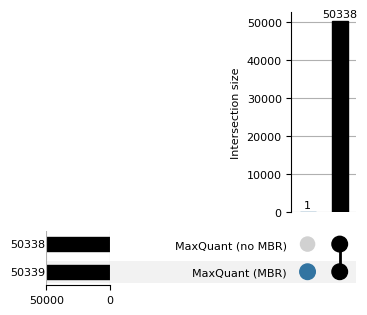

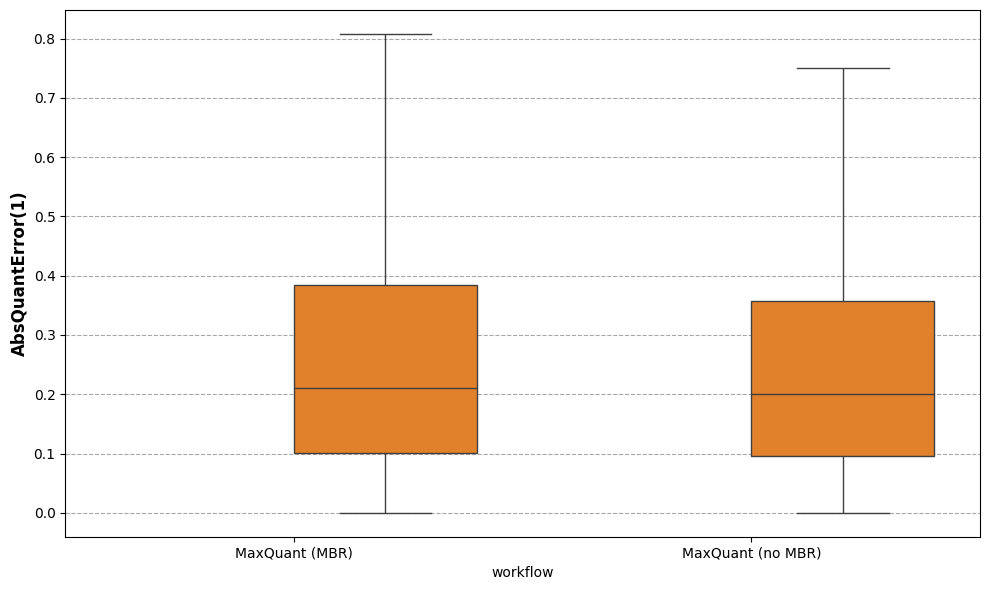

number of precursor ions before filtering:
47765
MaxQuant (MBR)
MaxQuant (no MBR)


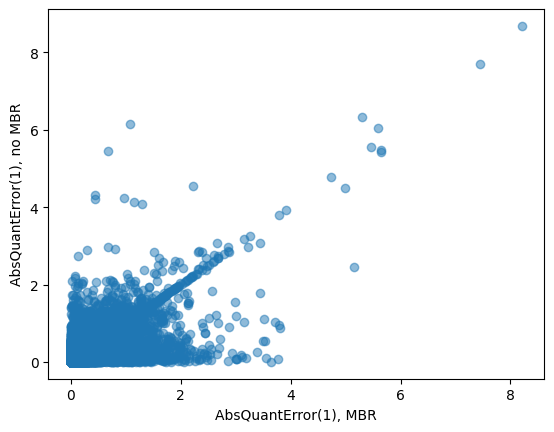

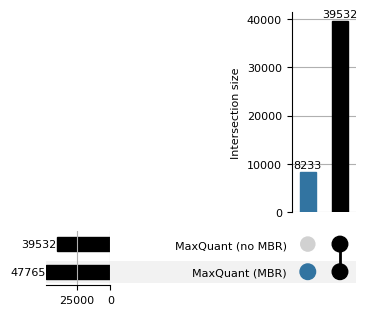

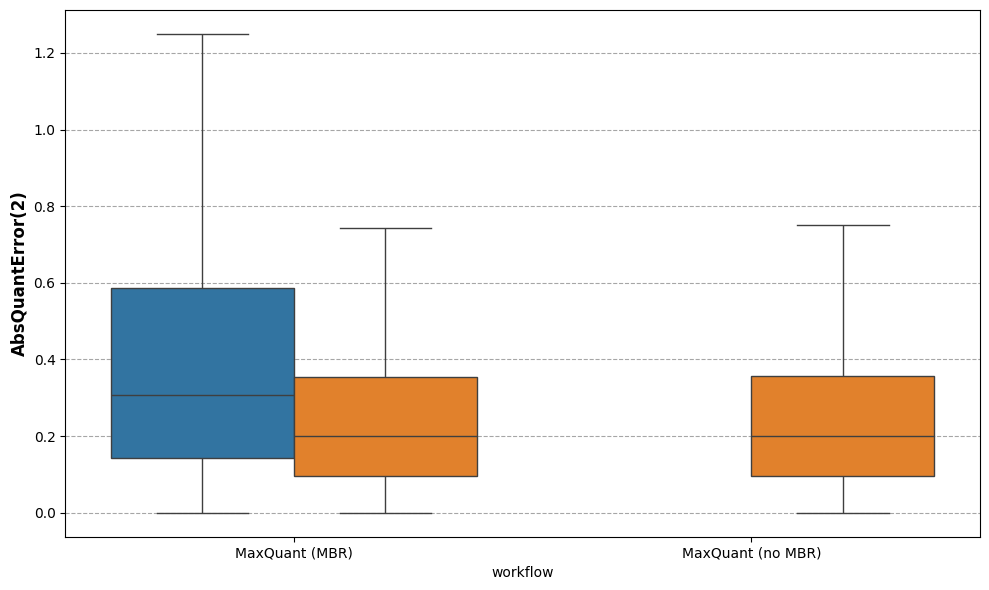

number of precursor ions before filtering:
43766
MaxQuant (MBR)
MaxQuant (no MBR)


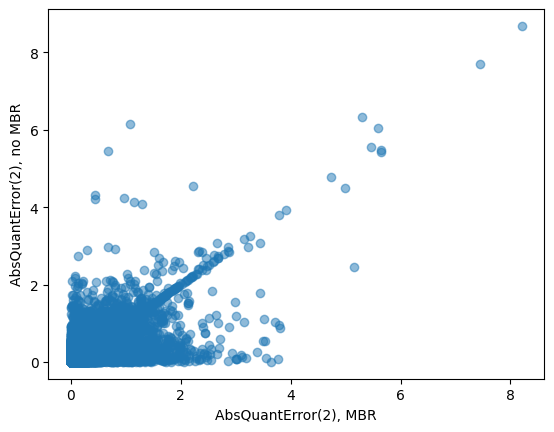

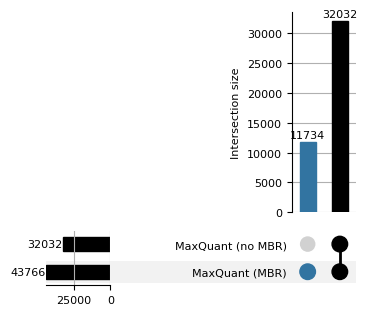

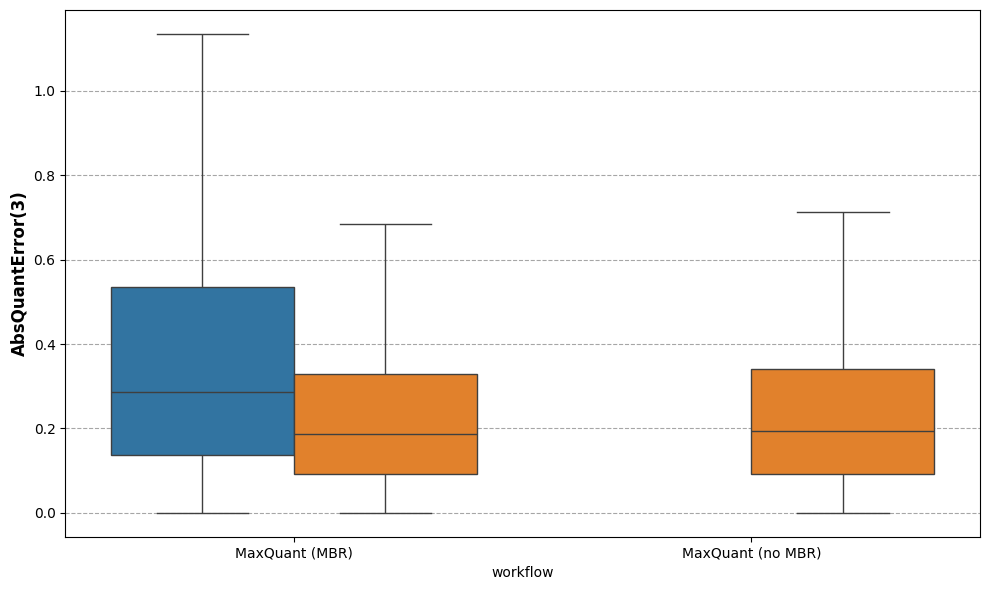

number of precursor ions before filtering:
38544
MaxQuant (MBR)
MaxQuant (no MBR)


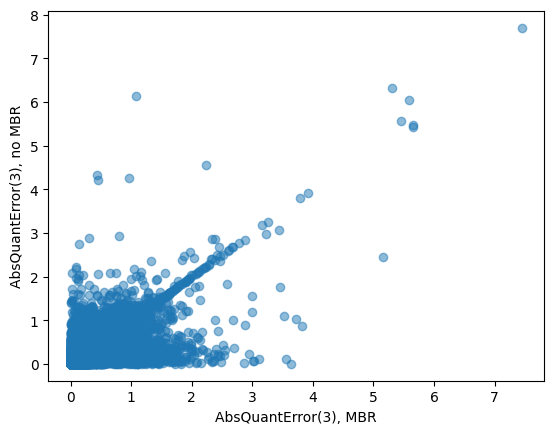

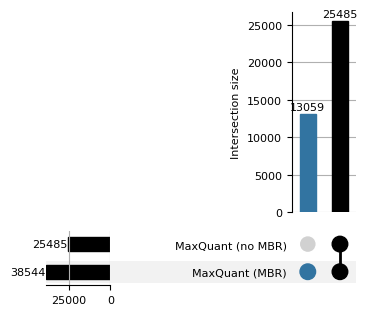

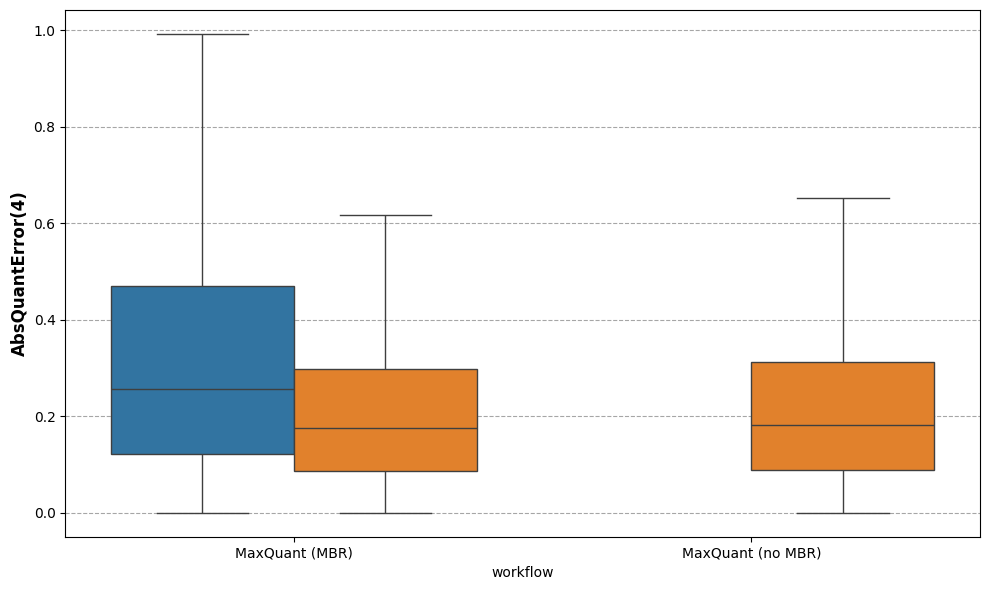

number of precursor ions before filtering:
32606
MaxQuant (MBR)
MaxQuant (no MBR)


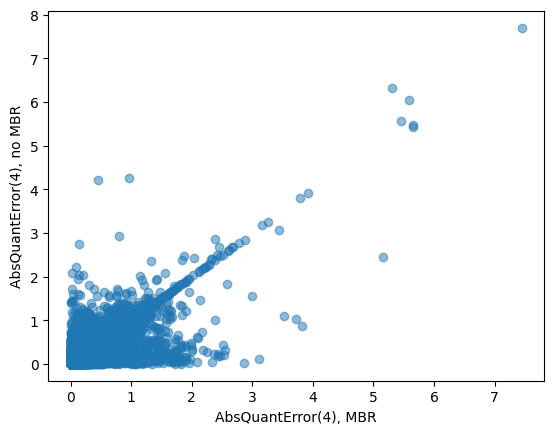

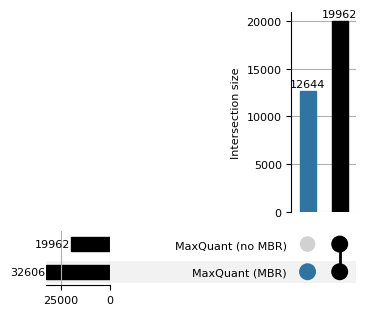

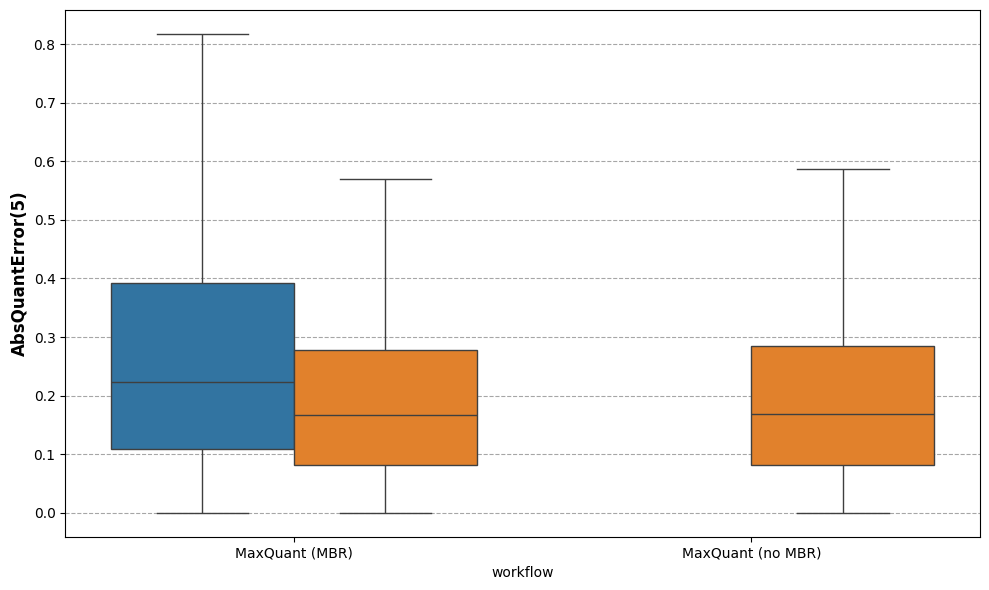

number of precursor ions before filtering:
25172
MaxQuant (MBR)
MaxQuant (no MBR)


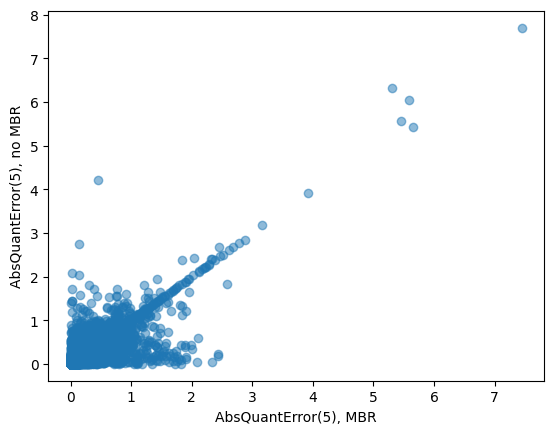

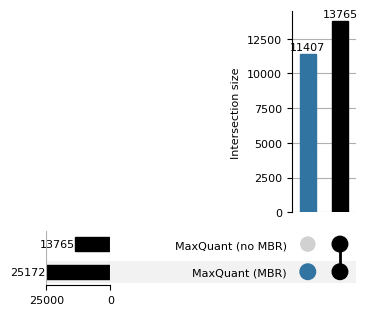

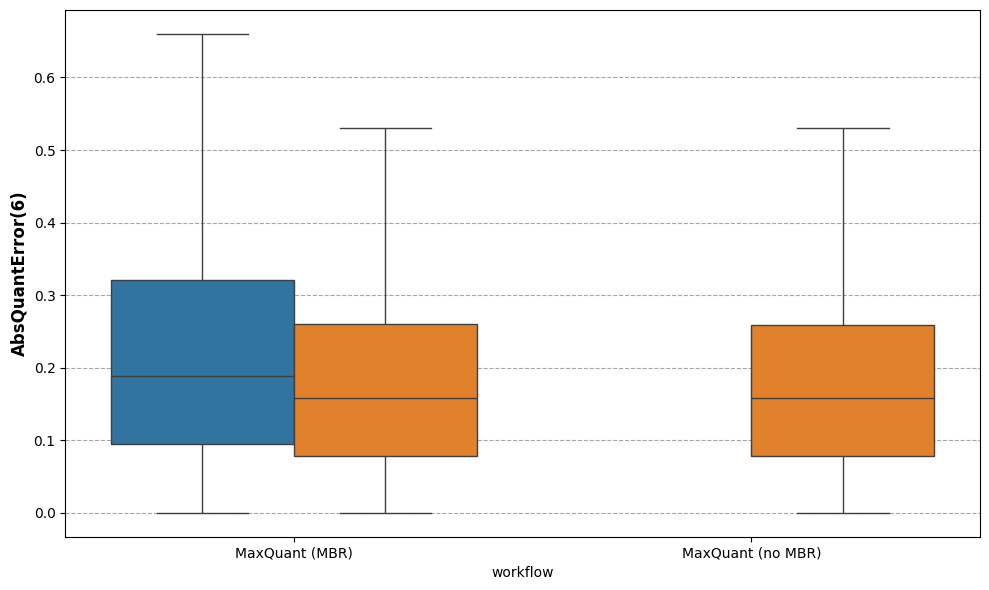

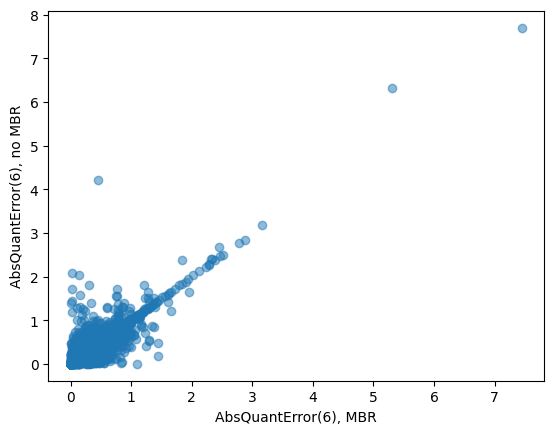

In [21]:
# suppl. fig 7

subset_hashes_MBR_MaxQuant = [
    "36b7b01b380f641722b3b34633bb53d72348eb80", # MaxQuant no MBR
    "8cbc0bce20eee581ad10326e02a09dbc316c30e1", # MaxQuant MBR
]

all_tools_mapper = {
    "[True, False]": "MaxQuant (MBR)",
    "[False, True]": "MaxQuant (no MBR)",
    "[True, True]": "all",
}

performance_df_dict = prepare_performance_dict_MBR_analysis(
    results_dict, mapper=None, subset=subset_hashes_MBR_MaxQuant
)

fig = plot_upset_and_boxplot_and_scatterplot_all_filters_MBR_analysis(
    performance_df_dict, all_tools_mapper, save_path="figures_manuscript/"
)


In [22]:
subset_hashes_MaxQuantVersions = [
    "8f4fa9a7dd1f44ac4ae7a7e7fb9b9606660f4578", # 1.5.2.8
    "f4f23a743baef55ba419a1cf0e8dd67a4cb5b7ac", # 1.5.3.30
    "5dc44925b46df18a2799648b5f975a41ba8bf89f", # 1.5.8.2
    "7912158e0522a315917e20fe434966ca9a17192e", #1.6.3.3
    "a1140a31b414d7b3110ee9b9c0456cc4f1709782", # 2.1.3.0
    "36b7b01b380f641722b3b34633bb53d72348eb80", #2.1.4.0
    "00e2f863939301a2a71178652972dad895b27520" #2.5.1.0
]

In [23]:
plot = plot_performance_metrics(
    all_datapoints, subset=subset_hashes_MaxQuantVersions, min_quant=3, subset_col="intermediate_hash", autoscale=True
)
plot

                          id software_name software_version search_engine  \
6   MaxQuant_20251007_142431      MaxQuant          1.5.2.8     Andromeda   
12  MaxQuant_20251007_142610      MaxQuant          2.1.4.0     Andromeda   
15  MaxQuant_20251007_142657      MaxQuant          2.5.1.0     Andromeda   
24  MaxQuant_20251007_142935      MaxQuant          2.1.3.0     Andromeda   
29  MaxQuant_20251007_143056      MaxQuant          1.5.8.2     Andromeda   
30  MaxQuant_20251007_143114      MaxQuant          1.6.3.3     Andromeda   
41  MaxQuant_20251007_143420      MaxQuant         1.5.3.30     Andromeda   

   search_engine_version ident_fdr_psm ident_fdr_peptide ident_fdr_protein  \
6                    NaN          0.01                                0.01   
12                   NaN          0.01                                0.01   
15                   NaN          0.01                                0.01   
24                   NaN          0.01                                0

# Intersection between all the search engines: How do the unique quantifications perform?

In [24]:
subset_hashes_1pertool = [
    "2a5ef6191b8098757d490acf76bb9c2af5b89a39", # MSAngel
"9d1361331b165d6cc779ccf614419eb77057f573", # PEAKS
#"d01e87b997b84c985868204b1ed26749902fd7f9", # quantms
"6ed9da37e9d4600a9a28968c9a01db2b967d33cb", # Proline Studio
# "bbd079eda4dd3d6a51b37924d83db50022530bb6", # Sage
#"4decb9e0d2d9ed9f9be6a9ad5aa066b1dcd1e616", # WOMBAT
"a3d801fcb75c46b2e76fa7078ae0a004360ebe44", # MaxQuant
"28b0c3b9853a5b60c9e47428b8a51b4898083523", # FragPipe
"90d852742aa152dc7ed813acebf7916b0c1d5b76", # i2masschroq
]

In [25]:
all_tools_mapper = {
    # FragPipe i2MassChroQ MaxQuant MSAngel ProlineStudio PEAKS
    "[True, False, False, False, False, False]": "FragPipe",
    "[False, True, False, False, False, False]": "i2MassChroQ",
    "[False, False, True, False, False, False]": "MaxQuant",
    "[False, False, False, True, False, False]": "MSAngel",
    "[False, False, False, False, True, False]": "ProlineStudio",
    "[False, False, False, False, False, True]": "PEAKS",
    "[True, True, True, True, True, False]": "all but PEAKS",
    "[True, True, True, True, False, True]": "all but ProlineStudio",
    "[True, True, True, False, True, True]": "all but MSAngel",
    "[True, True, False, True, True, True]": "all but MaxQuant",
    "[True, False, True, True, True, True]": "all but i2MassChroQ",
    "[False, True, True, True, True, True]": "all but FragPipe",
    "[True, True, True, True, True, True]": "all",

}

In [26]:
performance_df_dict = prepare_performance_dict(
    results_dict, mapper=None, subset=subset_hashes_1pertool
)

Processing FragPipe
Tool has the following runs: dict_keys(['28b0c3b9853a5b60c9e47428b8a51b4898083523'])
Processing 28b0c3b9853a5b60c9e47428b8a51b4898083523
Processing WOMBAT
Tool has the following runs: dict_keys([])
Processing i2MassChroQ
Tool has the following runs: dict_keys(['90d852742aa152dc7ed813acebf7916b0c1d5b76'])
Processing 90d852742aa152dc7ed813acebf7916b0c1d5b76
Processing MaxQuant
Tool has the following runs: dict_keys(['a3d801fcb75c46b2e76fa7078ae0a004360ebe44'])
Processing a3d801fcb75c46b2e76fa7078ae0a004360ebe44
Processing Sage
Tool has the following runs: dict_keys([])
Processing AlphaPept
Tool has the following runs: dict_keys([])
Processing MSAngel
Tool has the following runs: dict_keys(['2a5ef6191b8098757d490acf76bb9c2af5b89a39'])
Processing 2a5ef6191b8098757d490acf76bb9c2af5b89a39
Processing ProlineStudio
Tool has the following runs: dict_keys(['6ed9da37e9d4600a9a28968c9a01db2b967d33cb'])
Processing 6ed9da37e9d4600a9a28968c9a01db2b967d33cb
Processing quantms
Tool 

number of precursor ions before filtering:
95166
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


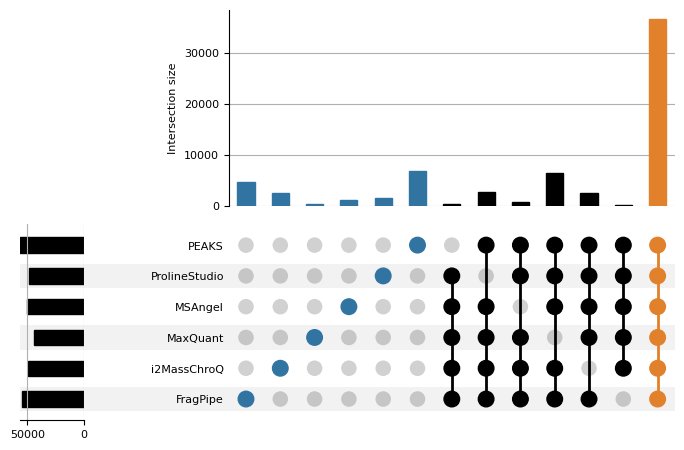

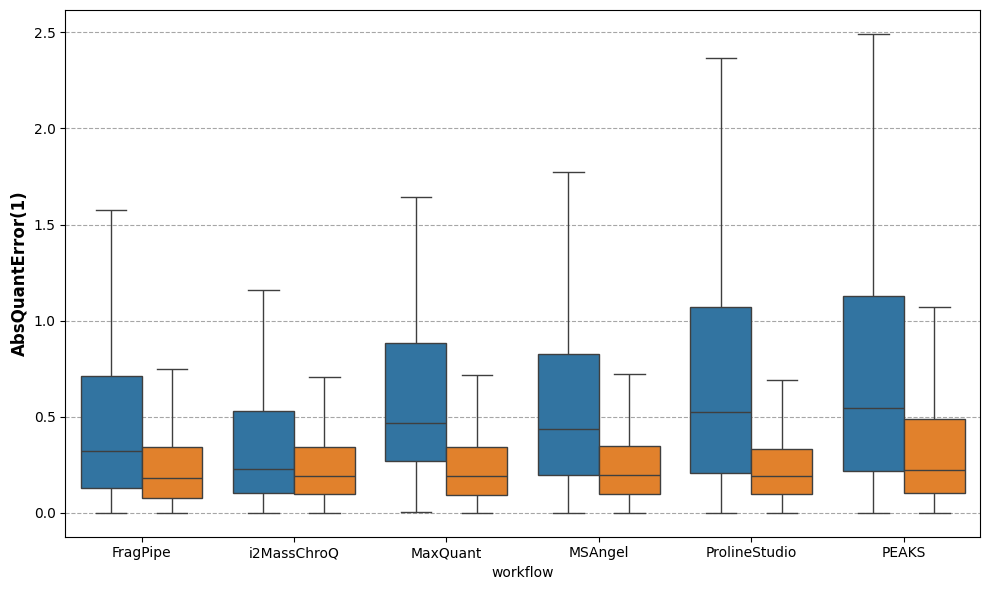

number of precursor ions before filtering:
90817
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


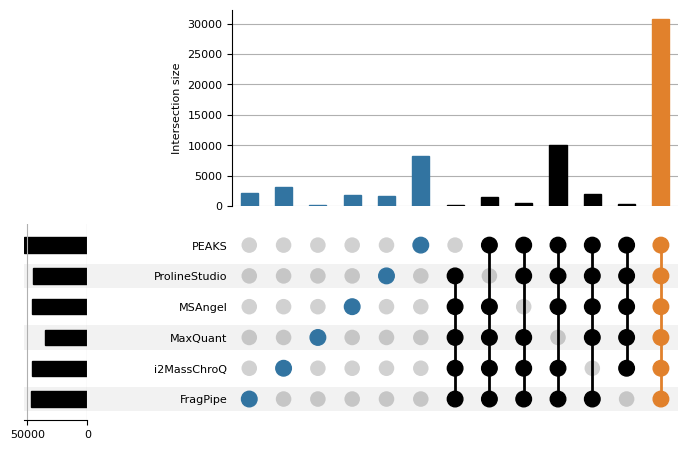

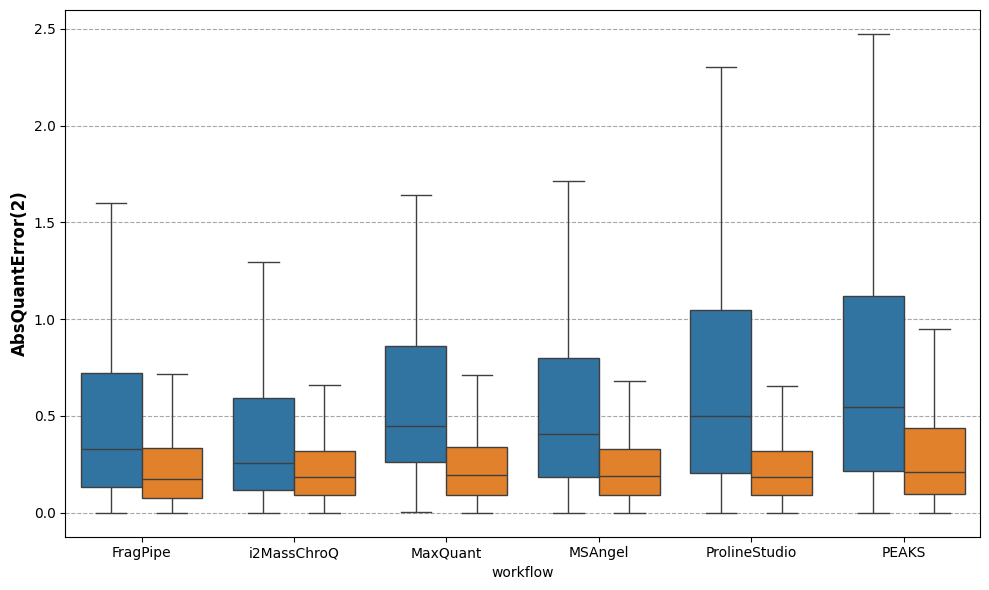

number of precursor ions before filtering:
87338
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


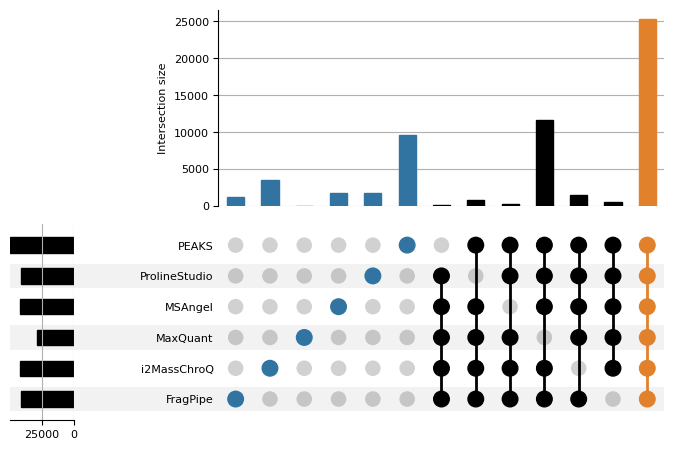

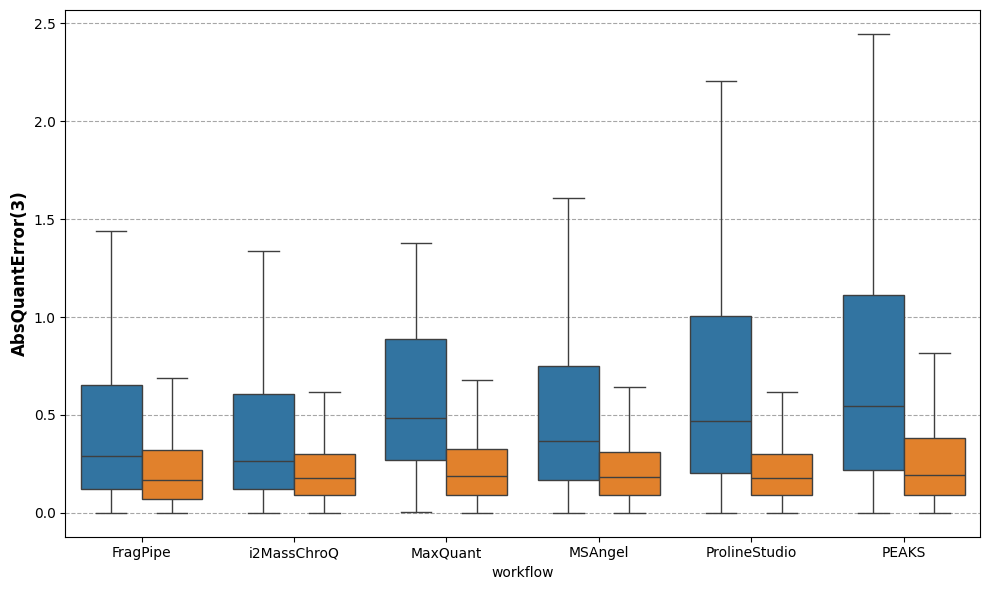

number of precursor ions before filtering:
83363
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


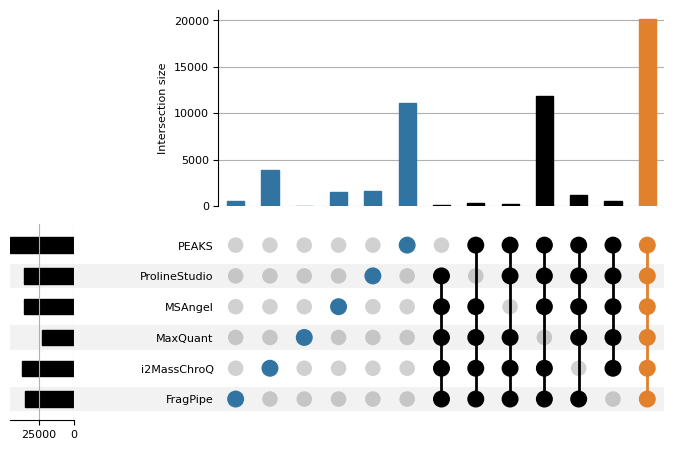

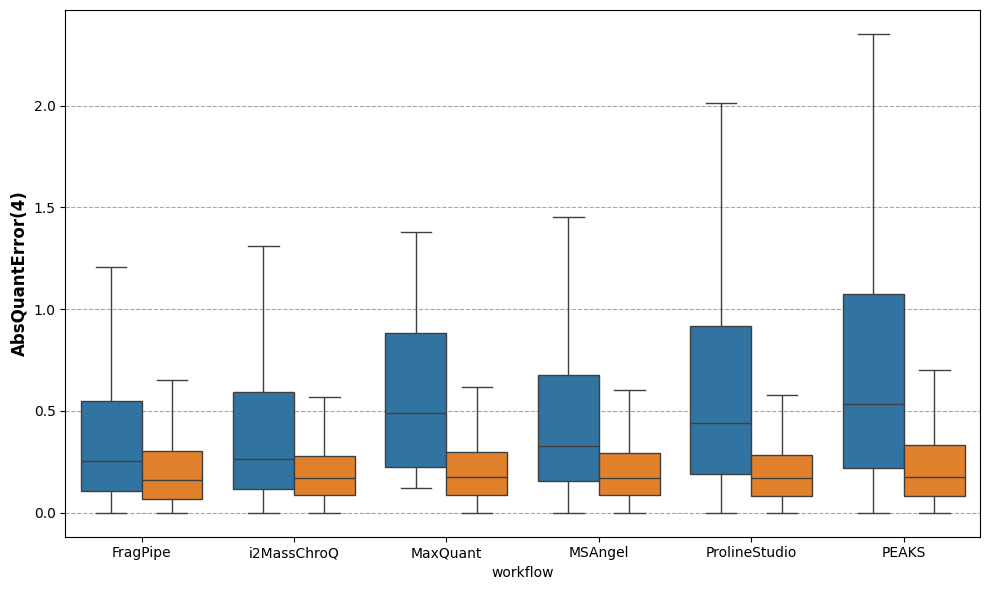

number of precursor ions before filtering:
78775
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


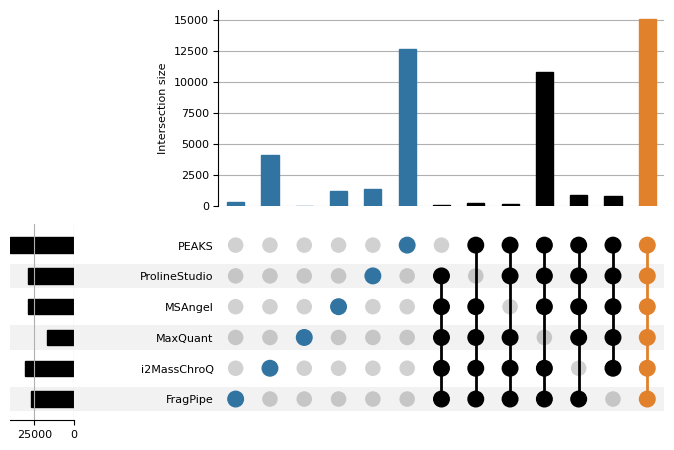

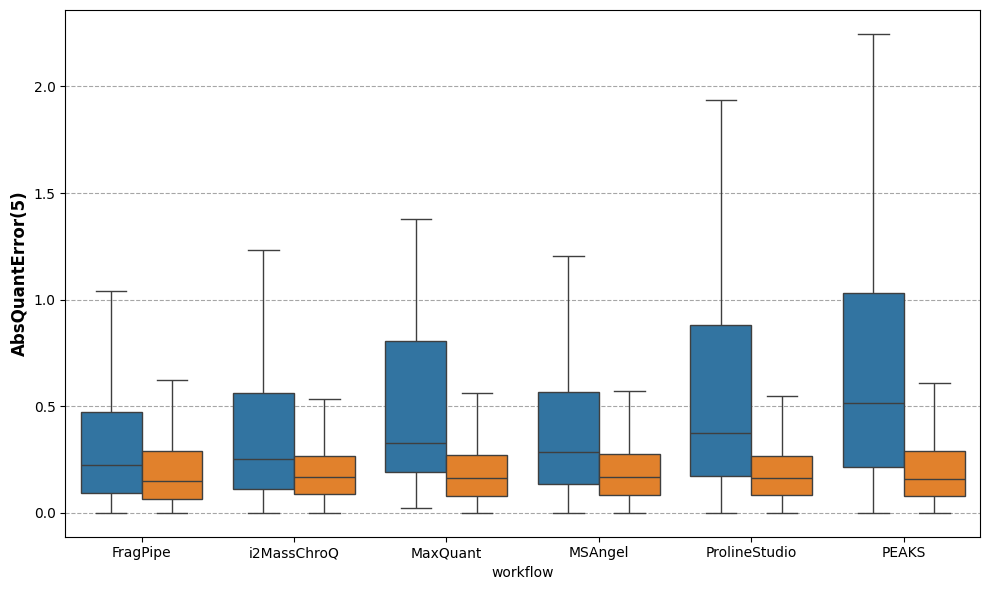

number of precursor ions before filtering:
72836
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


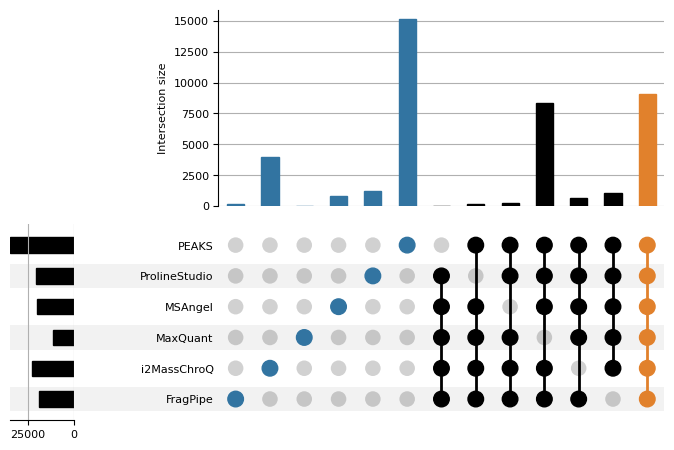

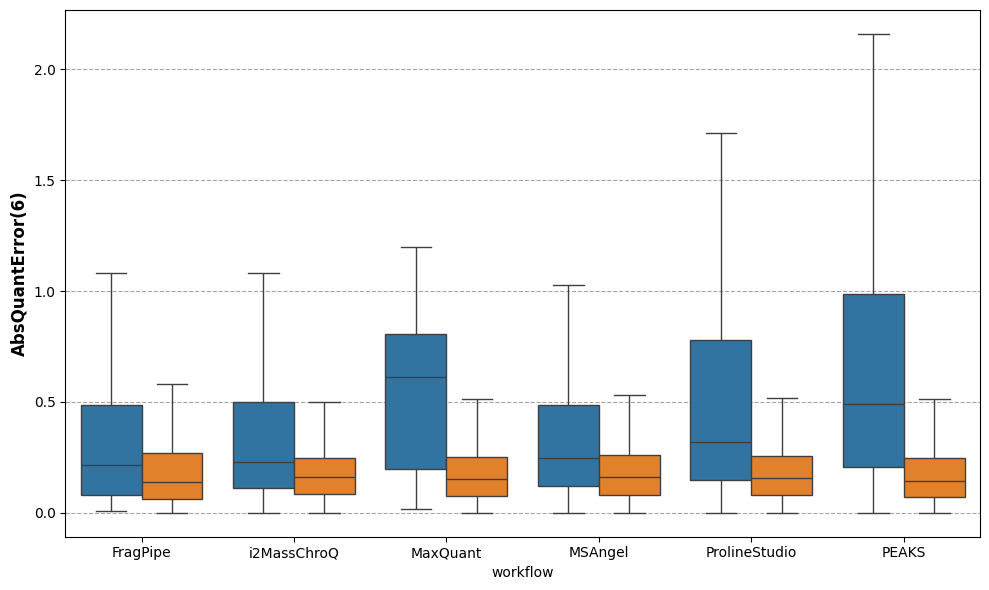

In [27]:
fig = plot_upset_and_boxplot_all_filters(
    performance_df_dict, all_tools_mapper, save_path="figures_manuscript/"
)

# A look at precursor quantification for e.coli and yeast precursors

In [28]:
def plot_pair_quantifications(
    results,
    subset,
):
    if subset:
        results = {
            k: {sk: v for sk, v in inner_dict.items() if sk in subset}
            for k, inner_dict in results.items()
        }

    lprec = {}
    for tool, subdict in results.items():
        for hashe, df in subdict.items():
            precursors = df["precursor ion"].unique()
            lprec[hashe] = precursors

    # prepare the data for the pair plot
    lplot = []
    for i, (tool, subdict) in enumerate(results.items()):
        for hashe, df in subdict.items():
            res = df[["precursor ion", "log2_A_vs_B", "species"]].copy()
            res["tool"] = tool
            lplot.append(res)

    gtab = pd.concat(lplot, ignore_index=True)
    gtab_wide = gtab.pivot_table(
        index=["species", "precursor ion"], columns="tool", values="log2_A_vs_B"
    )

    # Get limits for the plots
    lims = np.max(
        np.abs(gtab[gtab["species"].isin(["ECOLI", "YEAST"])]["log2_A_vs_B"].dropna())
    )
    lims = (-lims, lims)

    # Create the pair plot for E. coli
    ecoli = gtab_wide[
        gtab_wide.index.get_level_values("species") == "ECOLI"
    ].reset_index()
    g = sns.pairplot(
        ecoli.drop(columns=["species", "precursor ion"]), plot_kws={"alpha": 0.1}
    )

    # Apply same axis limits to all subplots in E. coli pairplot
    for i, ax in enumerate(g.axes.flatten()):
        # Skip the diagonal subplots (i.e., where row == column)
        if not i % len(g.axes) == i // len(g.axes):  # Diagonal check
            ax.axhline(y=-2, linestyle="--", linewidth=0.5)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.axvline(x=-2, linestyle="--", linewidth=0.5)

    plt.suptitle("E. coli Pairplot")
    plt.tight_layout()
    plt.show()

    # Plot for yeast
    yeast = gtab_wide[
        gtab_wide.index.get_level_values("species") == "YEAST"
    ].reset_index()
    g = sns.pairplot(
        yeast.drop(columns=["species", "precursor ion"]), plot_kws={"alpha": 0.1}
    )

    # Apply same axis limits to all subplots in Yeast pairplot
    for i, ax in enumerate(g.axes.flatten()):
        # Skip the diagonal subplots (i.e., where row == column)
        if not i % len(g.axes) == i // len(g.axes):  # Diagonal check
            ax.axhline(y=1, linestyle="--", linewidth=0.5)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.axvline(x=1, linestyle="--", linewidth=0.5)

    plt.suptitle("Yeast Pairplot")
    plt.tight_layout()
    # save svg
    plt.savefig("figures_manuscript/pair_quantifications.svg")
    plt.show()


def plot_pair_quantifications_combined(results, subset=None):
    """
    Create a combined pair plot comparing log2(A vs B) fold-changes across multiple tools
    using E. coli (lower triangle) and Yeast (upper triangle) precursor ions.

    Parameters:
        results (dict): Dictionary mapping tool name -> dict of {hash -> DataFrame} with
                        columns ['precursor ion', 'log2_A_vs_B', 'species'].
        subset (list, optional): List of tool names to include in the plot.
    """
    #print(results)
    # Filter hashes
    if subset:
        results = {
            k: {sk: v for sk, v in inner_dict.items() if sk in subset}
            for k, inner_dict in results.items()
        }

    tools = ["FragPipe", "i2MassChroQ", "MaxQuant", "MSAngel", "ProlineStudio", "PEAKS"]

    print(results.keys)

    # Aggregate DataFrames per tool
    tool_data = {}
    for tool in tools:
        dfs = [df.copy() for df in results[tool].values()]
        if len(dfs) > 0:
            tool_data[tool] = pd.concat(dfs, ignore_index=True)

    # Extract species-specific data for each tool, indexed by precursor ion
    e_coli_vals = {}
    yeast_vals = {}
    for tool, df in tool_data.items():
        ecoli_df = df[df["species"].str.upper() == "ECOLI"]
        yeast_df = df[df["species"].str.upper() == "YEAST"]
        e_coli_vals[tool] = ecoli_df.set_index("precursor ion")["log2_A_vs_B"]
        yeast_vals[tool] = yeast_df.set_index("precursor ion")["log2_A_vs_B"]

    # Determine global log2 limits
    all_vals = pd.concat(
        [s.dropna() for d in [e_coli_vals, yeast_vals] for s in d.values()]
    )
    lim = (
        np.ceil(np.percentile(np.abs(all_vals), 99.5)) * 1.1
        if not all_vals.empty
        else 1.0
    )

    # Colors
    col_ecoli = "#1f77b4"
    col_yeast = "#ff7f0e"

    n = len(tools)
    fig, axes = plt.subplots(n, n, figsize=(3 * n, 3 * n))

    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            tool_i = tools[i]
            tool_j = tools[j]

            if i == j:
                ec_vals = e_coli_vals[tool_i].dropna()
                yt_vals = yeast_vals[tool_i].dropna()
                if not ec_vals.empty:
                    sns.kdeplot(ec_vals, ax=ax, color=col_ecoli, fill=True, alpha=0.4)
                if not yt_vals.empty:
                    sns.kdeplot(yt_vals, ax=ax, color=col_yeast, fill=True, alpha=0.4)
                ax.axvline(-2, linestyle="--", color=col_ecoli, lw=1)
                ax.axvline(1, linestyle="--", color=col_yeast, lw=1)
                ax.set_xlim(-lim, lim)
                if not i == 0:
                    ax.yaxis.set_visible(False)
                if not j == n - 1:
                    ax.xaxis.set_visible(False)

            elif i > j:  # E. coli: lower triangle
                ax.set_facecolor(to_rgba(col_ecoli, alpha=0.1))
                x = e_coli_vals[tool_j]
                y = e_coli_vals[tool_i]
                common = x.index.intersection(y.index)
                ax.scatter(
                    x.loc[common], y.loc[common], color=col_ecoli, alpha=0.3, s=10, rasterized=True
                )
                ax.axhline(-2, linestyle="--", color="gray", lw=0.8)
                ax.axvline(-2, linestyle="--", color="gray", lw=0.8)
                ax.set_xlim(-lim, lim)
                ax.set_ylim(-lim, lim)

            else:  # Yeast: upper triangle
                ax.set_facecolor(to_rgba(col_yeast, alpha=0.1))
                x = yeast_vals[tool_j]
                y = yeast_vals[tool_i]
                common = x.index.intersection(y.index)
                ax.scatter(
                    x.loc[common], y.loc[common], color=col_yeast, alpha=0.3, s=10, rasterized=True
                )
                ax.axhline(1, linestyle="--", color="gray", lw=0.8)
                ax.axvline(1, linestyle="--", color="gray", lw=0.8)
                ax.set_xlim(-lim, lim)
                ax.set_ylim(-lim, lim)

            # Clean ticks
            if i < n - 1:
                ax.set_xticks([])
            else:
                ax.set_xlabel(tool_j)
            if j > 0:
                ax.set_yticks([])
            else:
                ax.set_ylabel(tool_i)

    # Final layout and legend
    fig.legend(
        handles=[
            plt.Line2D([0], [0], color=col_ecoli, lw=4, label="E. coli"),
            plt.Line2D([0], [0], color=col_yeast, lw=4, label="Yeast"),
        ],
        loc="upper right",
        bbox_to_anchor=(1.09, 0.99),
        title="Species",
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # save as svg
    plt.savefig("figures_manuscript/pair_quantifications_combined.svg")

    plt.show()

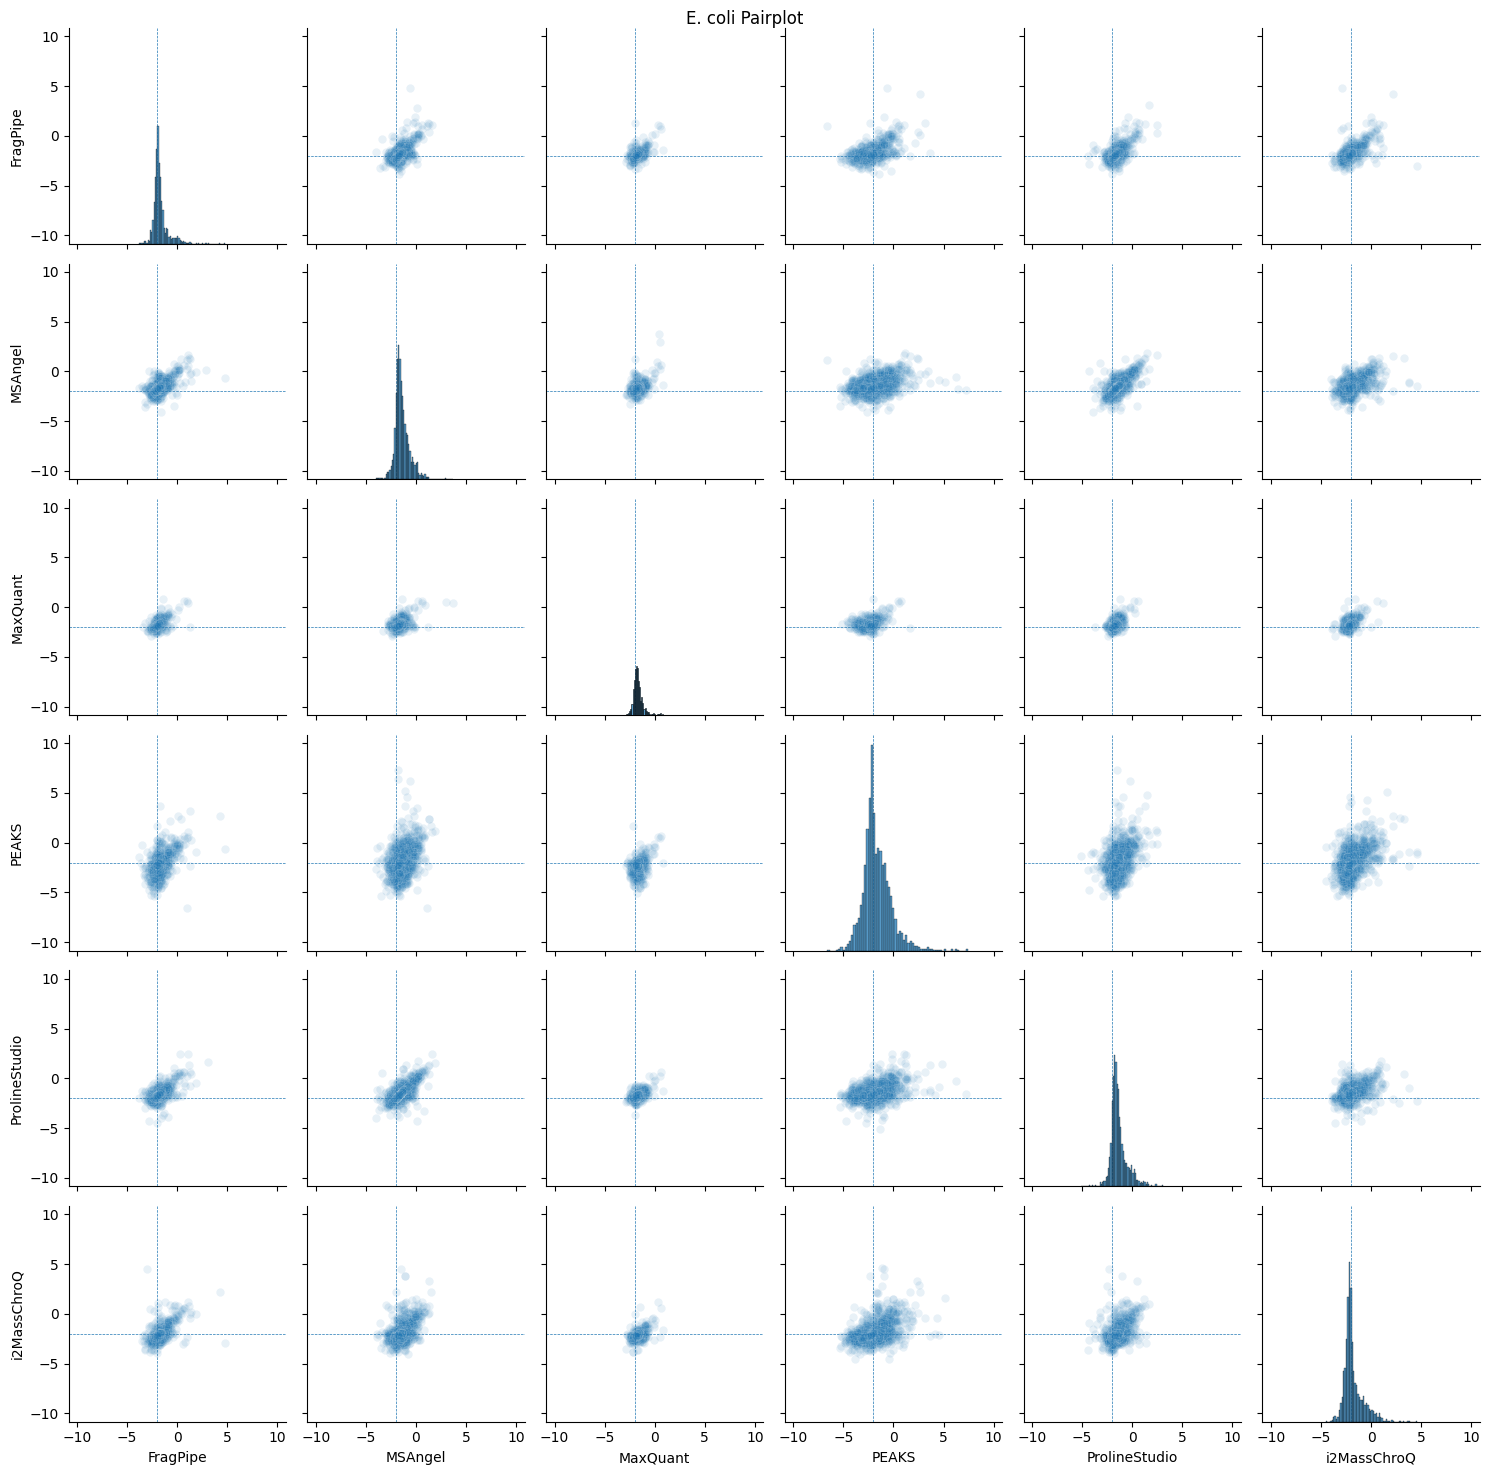

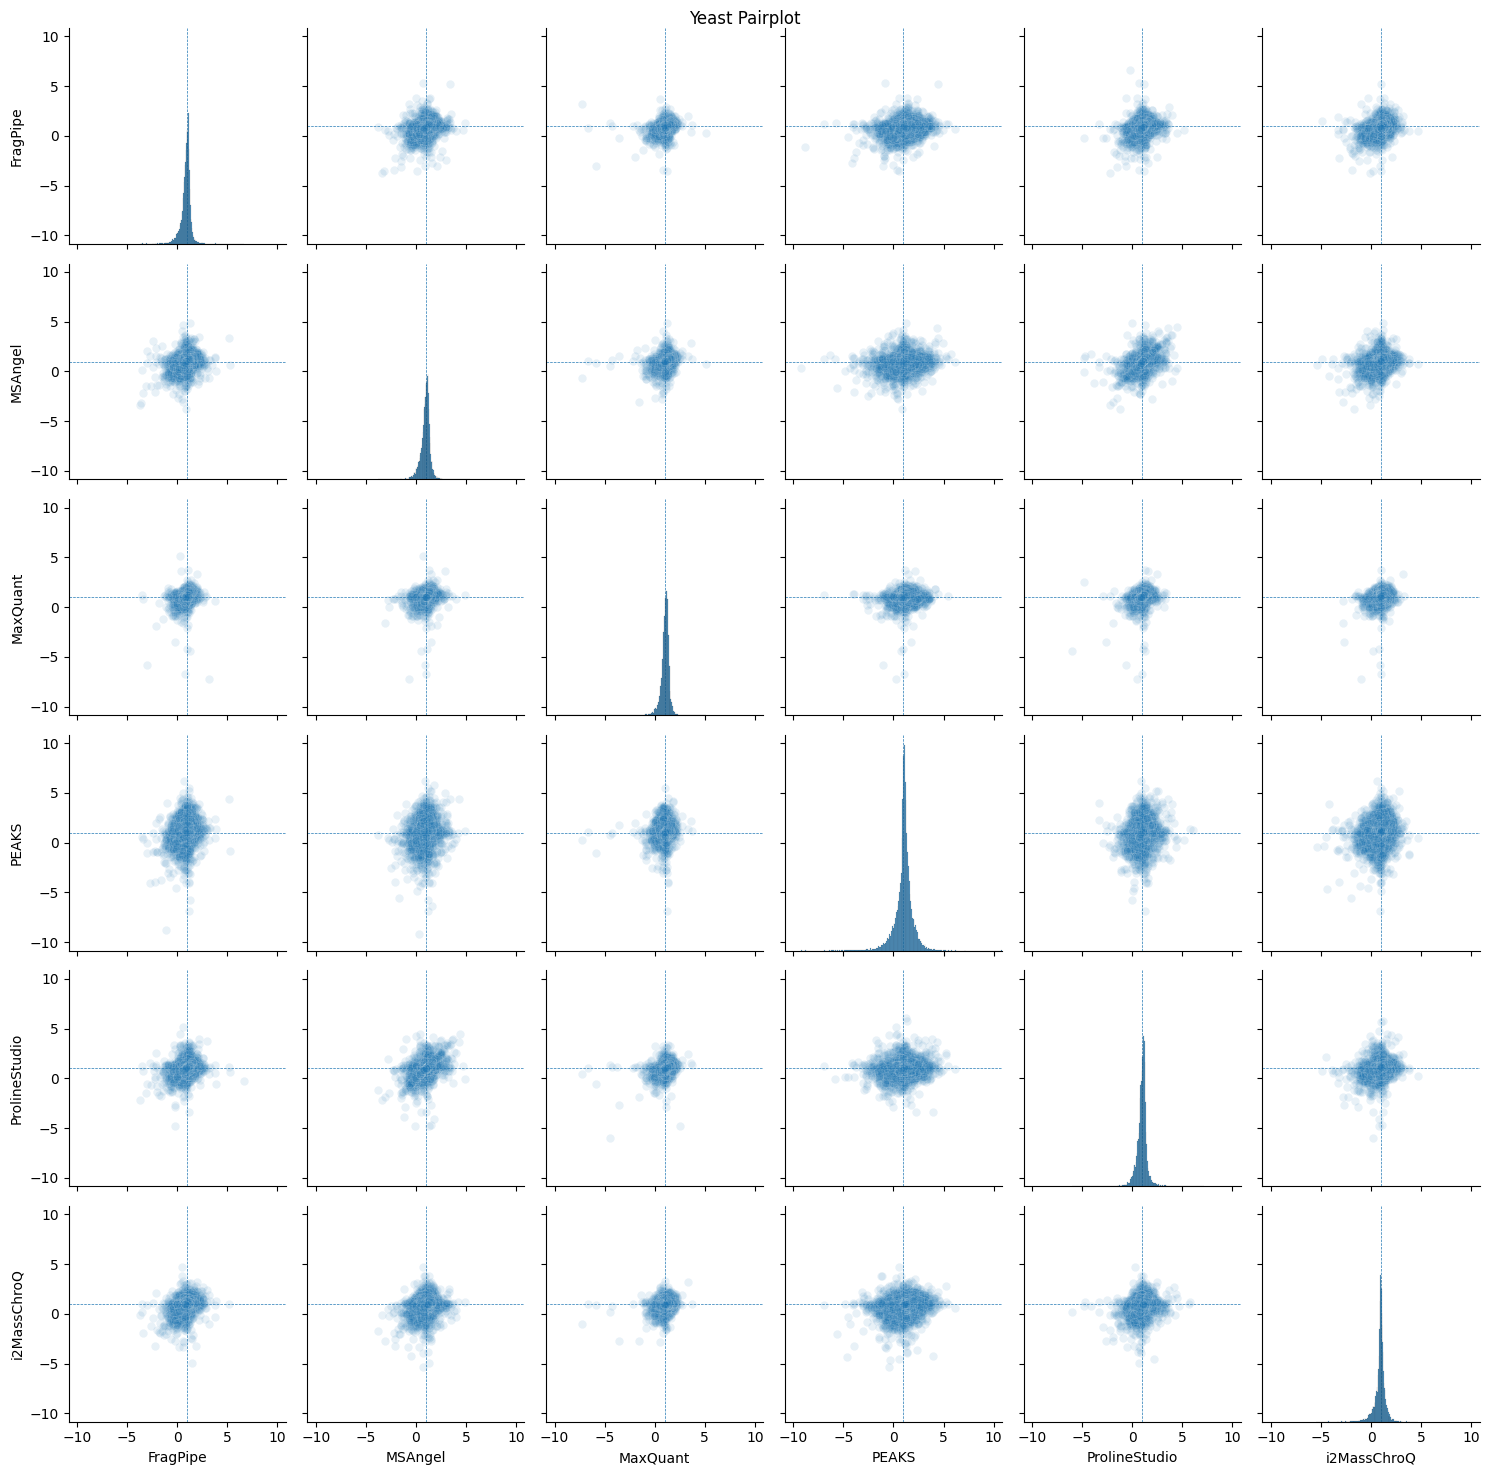

In [29]:
results = plot_pair_quantifications(results_dict, subset=subset_hashes_1pertool)

<built-in method keys of dict object at 0x7f14c6c84bc0>


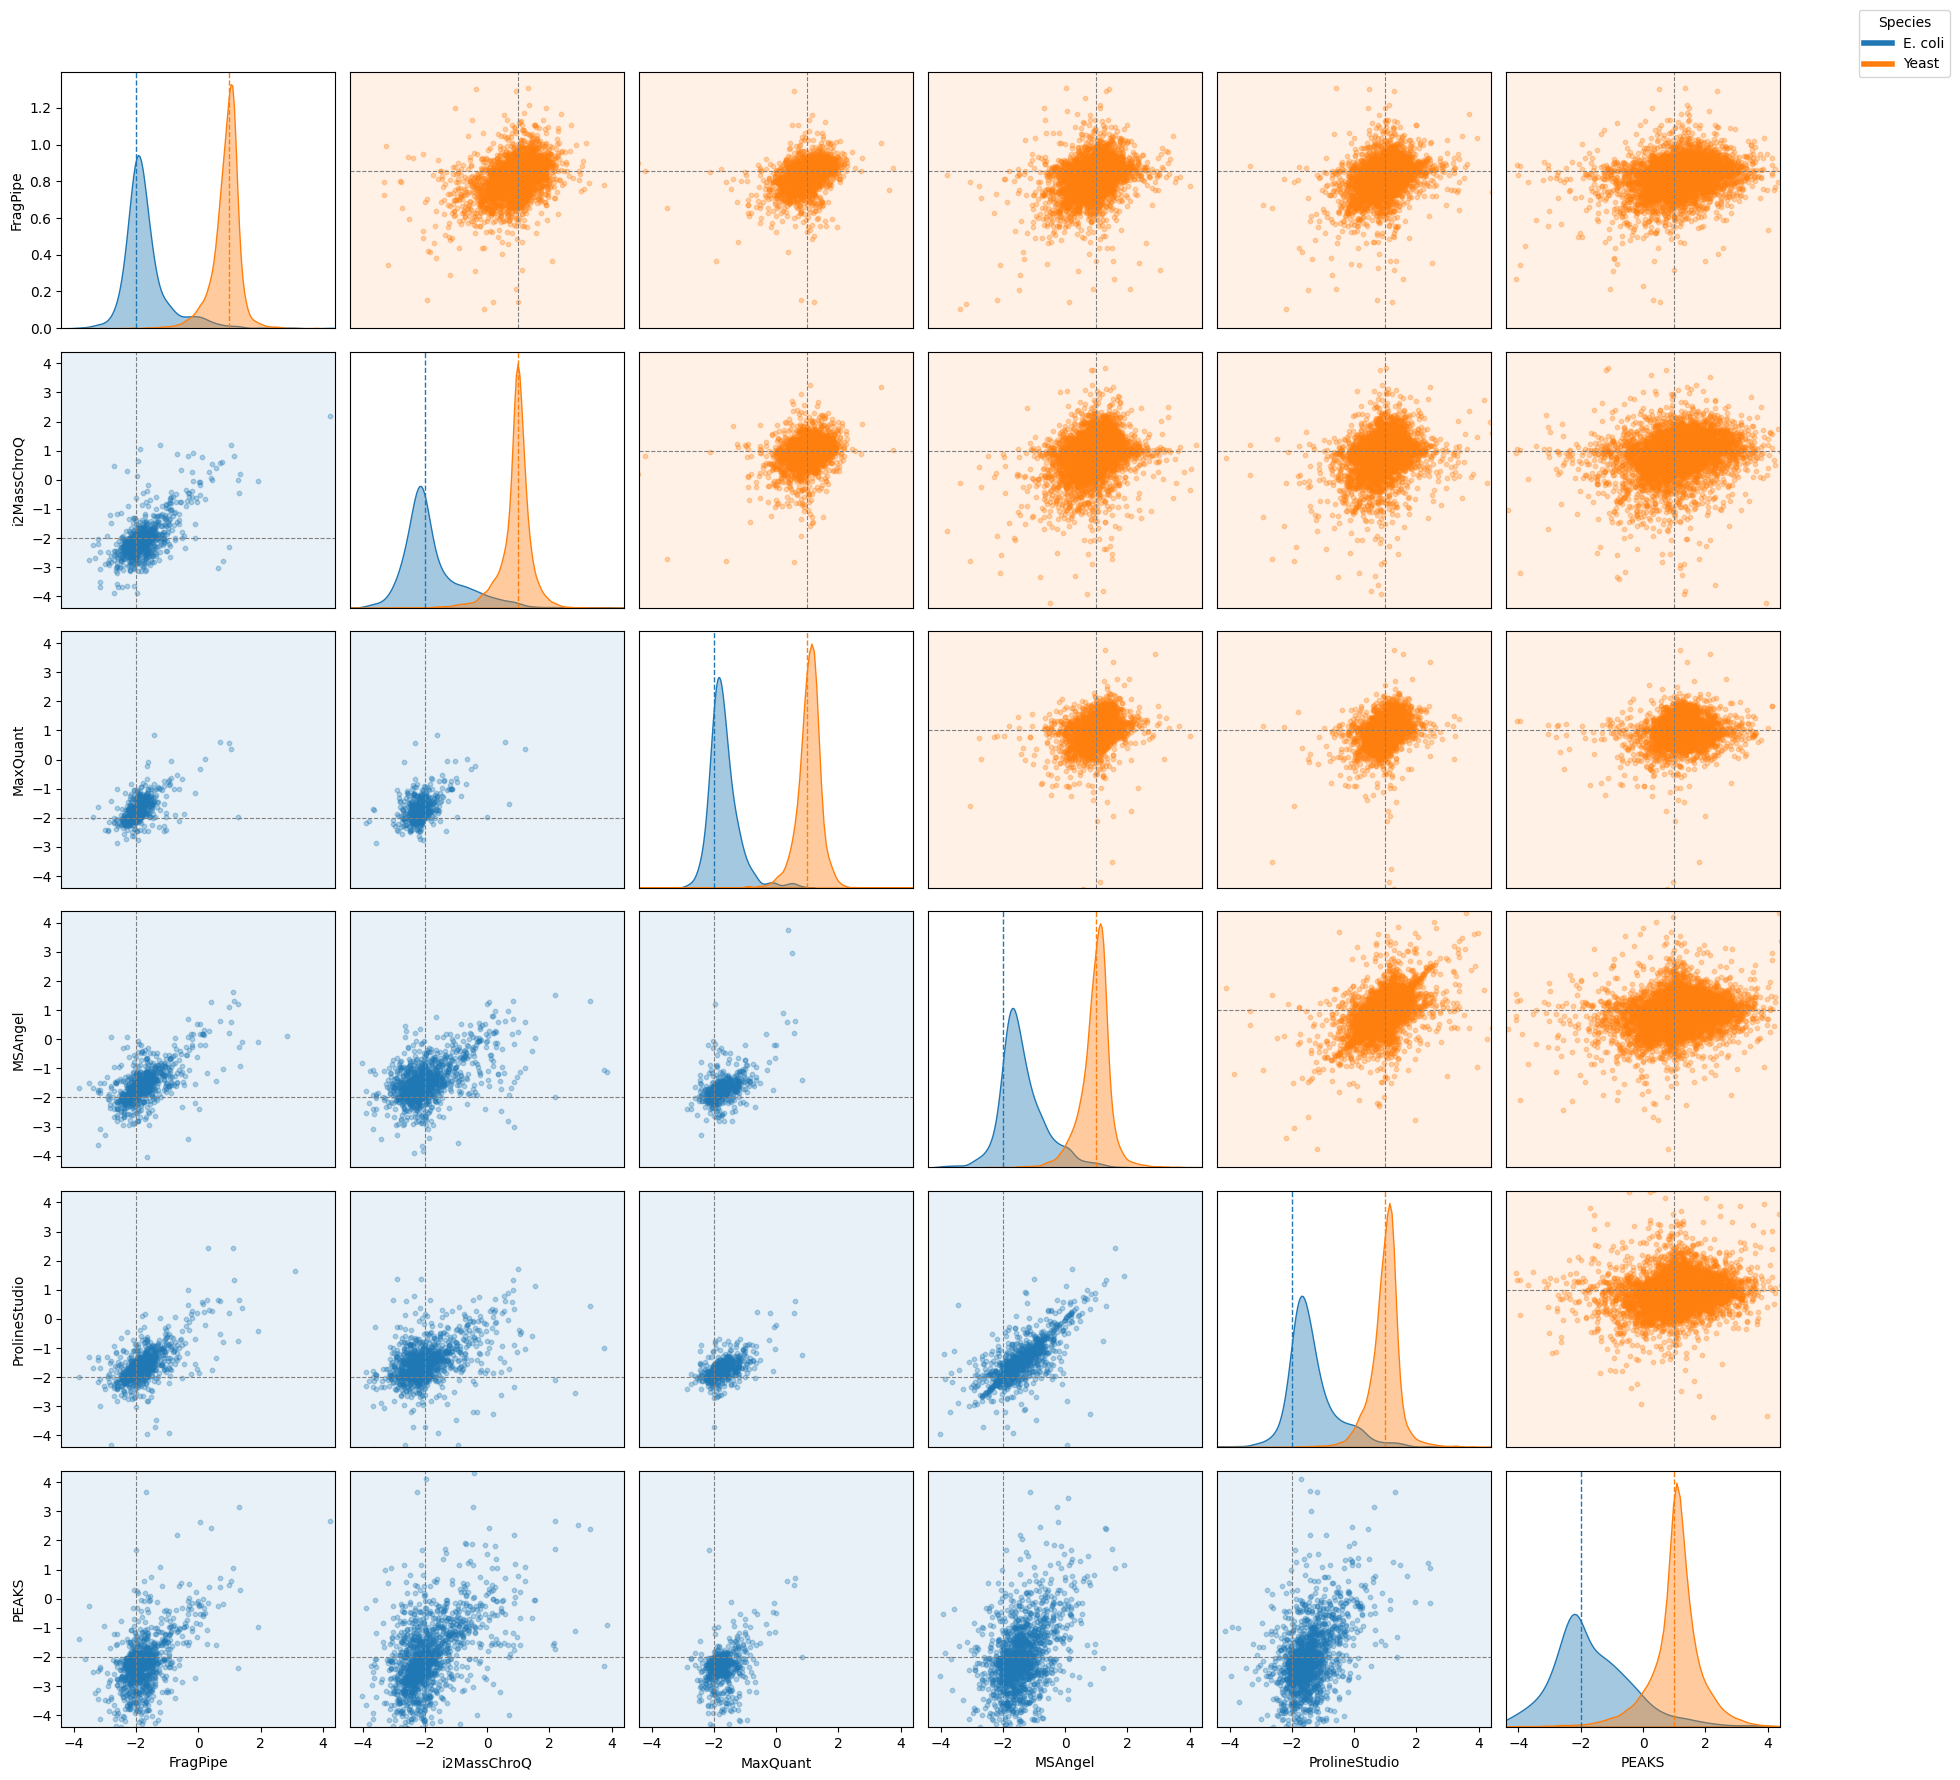

In [30]:
plot_pair_quantifications_combined(results_dict, subset=subset_hashes_1pertool)

# Quantified in more runs -> higher intensity?

Processing FragPipe
Tool has the following runs: dict_keys([])
Processing WOMBAT
Tool has the following runs: dict_keys([])
Processing i2MassChroQ
Tool has the following runs: dict_keys([])
Processing MaxQuant
Tool has the following runs: dict_keys(['a3d801fcb75c46b2e76fa7078ae0a004360ebe44'])
Processing a3d801fcb75c46b2e76fa7078ae0a004360ebe44
Processing Sage
Tool has the following runs: dict_keys([])
Processing AlphaPept
Tool has the following runs: dict_keys([])
Processing MSAngel
Tool has the following runs: dict_keys([])
Processing ProlineStudio
Tool has the following runs: dict_keys([])
Processing quantms
Tool has the following runs: dict_keys([])
Processing PEAKS
Tool has the following runs: dict_keys([])


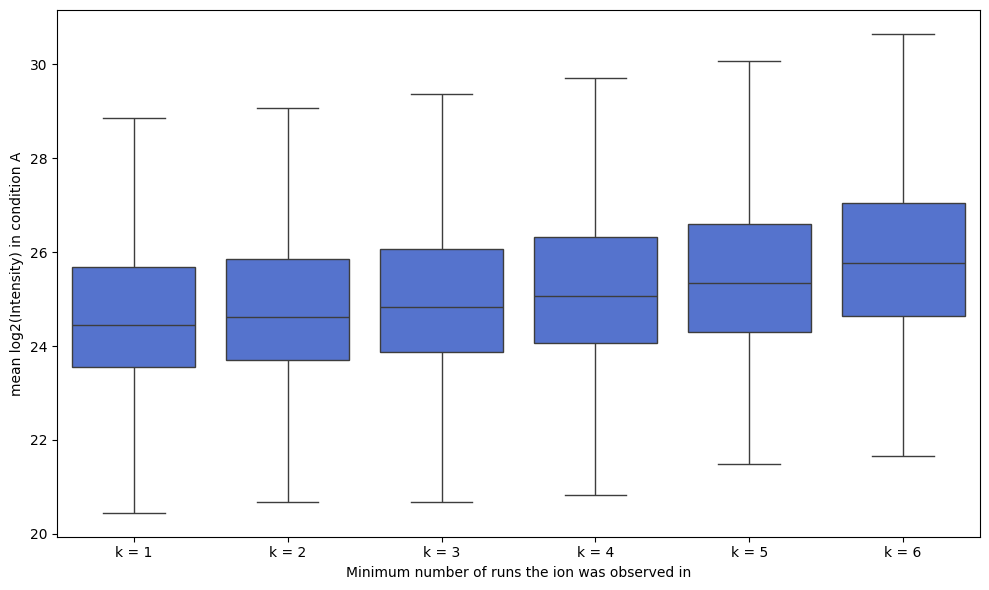

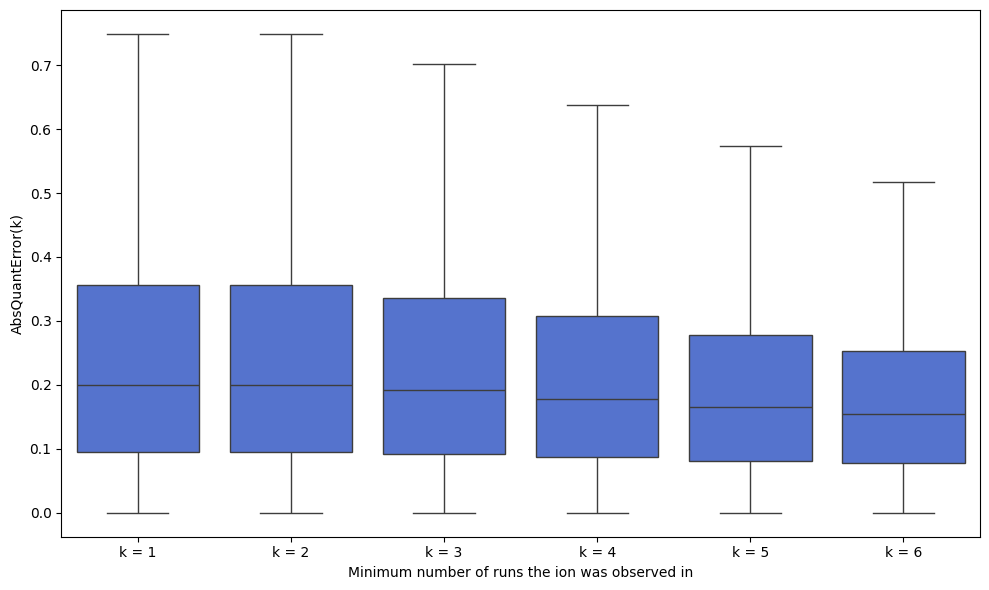

In [34]:
subset_hashes_example = [
"a3d801fcb75c46b2e76fa7078ae0a004360ebe44", # MaxQuant
]

performance_df_dict = prepare_performance_dict(
    results_dict, mapper=None, subset=subset_hashes_example
)

fig = plot_filtered_intensity_boxplots(
    performance_df_dict
)

## Check which search engines perform methionine excision

In [36]:
fasta =  "ProteoBenchFASTA_MixedSpecies_HYE.fasta"
# get all tryptic peptides from the fasta file that are at the beginning of the sequence

from typing import List, Tuple, Iterable
from pyteomics import fasta as pyfasta
from pyteomics.parser import cleave, expasy_rules

def nterm_tryptic_peptides_with_mc(
    fasta_path: str,
    min_length: int = 7,
    missed_cleavages: int = 2,
) -> List[Tuple[str, str]]:
    """
    Return all N-terminal tryptic peptides from proteins that start with M,
    allowing up to `missed_cleavages` and keeping only peptides with length >= `min_length`.
    """
    results: List[Tuple[str, str]] = []
    rule = expasy_rules['trypsin']

    # IMPORTANT: iterate over the GENERATOR returned by pyteomics.fasta.read(...)
    for header, seq in pyfasta.read(fasta_path):
        s = (seq or "").replace('*', '').replace('\n', '').replace('\r', '').upper()
        if not s.startswith('M'):
            continue

        # Generate tryptic peptides (fully tryptic, with missed cleavages & min length)
        peps: Iterable[str] = cleave(
            s,
            rule,
            missed_cleavages=missed_cleavages,
            min_length=min_length
        )

        prot_id = header.split()[0]
        for p in peps:
            if s.startswith(p):
                results.append(p)

    return list(set(results))


In [37]:
n_term_peptides = nterm_tryptic_peptides_with_mc(fasta)
n_term_peptides

['MQRPEAWPRPHPGEGAAAAQAGGPAPPARAGEPSGLR',
 'MTELQSALLLR',
 'MMGRNGIR',
 'MFAAGLAPFYASNFSLWSAAYCSSAGPGGCSFPLDPAAVK',
 'MLFLQFLLLALLLPGGDNADASQEHVSFHVIQIFSFVNQSWARGQGSGWLDELQTHGWDSESGTIIFLHNWSK',
 'MSISFPK',
 'MPGRARTR',
 'MPGEATETVPATEQELPQPQAETAVLPMSSALSVTAALGQPGPTLPPPCSPAPQQCPLSAANQASPFPSPSTIASTPLEVPFPQSSSGTALPLGTAPEAPTFLPNLIGPPISPAALALASPMIAPTLK',
 'MKFQVVLSALLACSSAVVASPIENLFK',
 'MNLFFVFFFVFFWSDLVEGQSVFVGLGR',
 'MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDK',
 'MAEDVSSAAPSPR',
 'MNLVDLWLTRSLSMCLLLQSFVLMILCFHSASMCPKGCLCSSSGGLNVTCSNANLK',
 'MAWTLLLLVLLSHCTGSLSQPVLTQPSSHSASSGASVR',
 'MDSSLLQAIEEIEKFFQHLSERHTEQAETPDAPEPQNCMPLTAHAEESQHESTQSK',
 'MDFSPSSELGFHFVAFILLTR',
 'MCSEARLAR',
 'MPNQGEDCYFFFYSTCTKGDSCPFRHCEAALGNETVCTLWQEGR',
 'MDLMNGQASSVNIAATASEK',
 'MENKTEVTQFILLGLTNDSELQVPLFITFPFIYIITLVGNLGIIVLIFWDSCLHNPMYFFLSNLSLVDFCYSSAVTPIVMAGFLIEDKVISYNACAAQMYIFVAFATVENYLLASMAYDR',
 'MACAVFQIPPWHLDRK',
 'MKNFEVLQPLQNSLSGLPLWVSER',
 'MTSLMPGAGLLPIPTPNPLTTLGVSLSSLGAIPAAALDPNIATLGEIPQPPLMGNVDPSK',
 'MAKERALT

In [38]:
n_term_peptides_excision = [p[1:] for p in n_term_peptides]
n_term_peptides_excision

['QRPEAWPRPHPGEGAAAAQAGGPAPPARAGEPSGLR',
 'TELQSALLLR',
 'MGRNGIR',
 'FAAGLAPFYASNFSLWSAAYCSSAGPGGCSFPLDPAAVK',
 'LFLQFLLLALLLPGGDNADASQEHVSFHVIQIFSFVNQSWARGQGSGWLDELQTHGWDSESGTIIFLHNWSK',
 'SISFPK',
 'PGRARTR',
 'PGEATETVPATEQELPQPQAETAVLPMSSALSVTAALGQPGPTLPPPCSPAPQQCPLSAANQASPFPSPSTIASTPLEVPFPQSSSGTALPLGTAPEAPTFLPNLIGPPISPAALALASPMIAPTLK',
 'KFQVVLSALLACSSAVVASPIENLFK',
 'NLFFVFFFVFFWSDLVEGQSVFVGLGR',
 'SSSSWLLLSLVAVTAAQSTIEEQAKTFLDK',
 'AEDVSSAAPSPR',
 'NLVDLWLTRSLSMCLLLQSFVLMILCFHSASMCPKGCLCSSSGGLNVTCSNANLK',
 'AWTLLLLVLLSHCTGSLSQPVLTQPSSHSASSGASVR',
 'DSSLLQAIEEIEKFFQHLSERHTEQAETPDAPEPQNCMPLTAHAEESQHESTQSK',
 'DFSPSSELGFHFVAFILLTR',
 'CSEARLAR',
 'PNQGEDCYFFFYSTCTKGDSCPFRHCEAALGNETVCTLWQEGR',
 'DLMNGQASSVNIAATASEK',
 'ENKTEVTQFILLGLTNDSELQVPLFITFPFIYIITLVGNLGIIVLIFWDSCLHNPMYFFLSNLSLVDFCYSSAVTPIVMAGFLIEDKVISYNACAAQMYIFVAFATVENYLLASMAYDR',
 'ACAVFQIPPWHLDRK',
 'KNFEVLQPLQNSLSGLPLWVSER',
 'TSLMPGAGLLPIPTPNPLTTLGVSLSSLGAIPAAALDPNIATLGEIPQPPLMGNVDPSK',
 'AKERALTLEALR',
 'TQTLLAIENLSVGF

In [39]:
performance_df_dict = prepare_performance_dict(
    results_dict, mapper=None
)

Processing FragPipe
Tool has the following runs: dict_keys(['45486140efcbe205e2485f1ef4d668ec3d79fb99', 'b9f217a22df2e15b1144830498fcb65f1dbcff57', '28b0c3b9853a5b60c9e47428b8a51b4898083523', 'c8041832abc601c03d5d021e0f0df6f48ae08428', '95eea5d8f0d1091dae5162cd9e7c58a66cb15670', '88dfa519f8ea30521e209ef1c005eee9ac38e555', '3bd27fcfd7013d81b578e850035874af14b1cc26'])
Processing 45486140efcbe205e2485f1ef4d668ec3d79fb99
Processing b9f217a22df2e15b1144830498fcb65f1dbcff57
Processing 28b0c3b9853a5b60c9e47428b8a51b4898083523
Processing c8041832abc601c03d5d021e0f0df6f48ae08428
Processing 95eea5d8f0d1091dae5162cd9e7c58a66cb15670
Processing 88dfa519f8ea30521e209ef1c005eee9ac38e555
Processing 3bd27fcfd7013d81b578e850035874af14b1cc26
Processing WOMBAT
Tool has the following runs: dict_keys(['6636a8c845b94a386a2f8ab8827e47e13dd87761', 'c9b6df263cfd4491f6188ac49043fa78d0f8acdb', '4decb9e0d2d9ed9f9be6a9ad5aa066b1dcd1e616', '58dfec050e16a3ff10999c76d727f23a5cd6c6f9', '6d76320c19398352cfbe0a0333e88d5e

In [40]:
# get all peptides per tool

peptides_dict = {}

# store number of n_term_peptides_excision per tool and plot it
n_term_peptides_excision_counts = {}

for tool, df_list in performance_df_dict.items():
    for df in df_list:
        peptides_dict[tool] = df['precursor ion'].unique().tolist()
        # strip the peptidoform
        peptides_dict[tool] = [strip_peptidoform(pept) for pept in peptides_dict[tool]]
        # remove charges
        peptides_dict[tool] = [pept.split("|Z=")[0] for pept in peptides_dict[tool]]

        peptides_dict[tool] = list(set(peptides_dict[tool]))  # remove duplicates

        # for each tool, print how many peptides are in n_term_peptides
        n_term_peptides_count = len(set(peptides_dict[tool]) & set(n_term_peptides))
        print(f"{tool}: {n_term_peptides_count} N-terminal peptides found in {len(peptides_dict[tool])} total peptides.")

        # for each tool, print how many peptides are in n_term_peptides_excision
        n_term_peptides_excision_count = len(set(peptides_dict[tool]) & set(n_term_peptides_excision))
        print(f"{tool}: {n_term_peptides_excision_count} N-terminal peptides with excision found in {len(peptides_dict[tool])} total peptides.")

        if tool not in n_term_peptides_excision_counts:
            n_term_peptides_excision_counts[tool] = []
        n_term_peptides_excision_counts[tool].append(n_term_peptides_excision_count)

n_term_peptides_excision_counts


FragPipe: 0 N-terminal peptides found in 64130 total peptides.
FragPipe: 0 N-terminal peptides with excision found in 64130 total peptides.
FragPipe: 0 N-terminal peptides found in 51509 total peptides.
FragPipe: 0 N-terminal peptides with excision found in 51509 total peptides.
FragPipe: 0 N-terminal peptides found in 73658 total peptides.
FragPipe: 0 N-terminal peptides with excision found in 73658 total peptides.
FragPipe: 0 N-terminal peptides found in 92937 total peptides.
FragPipe: 0 N-terminal peptides with excision found in 92937 total peptides.
FragPipe: 0 N-terminal peptides found in 51562 total peptides.
FragPipe: 0 N-terminal peptides with excision found in 51562 total peptides.
FragPipe: 0 N-terminal peptides found in 64130 total peptides.
FragPipe: 0 N-terminal peptides with excision found in 64130 total peptides.
FragPipe: 0 N-terminal peptides found in 65463 total peptides.
FragPipe: 0 N-terminal peptides with excision found in 65463 total peptides.
WOMBAT: 0 N-terminal

{'FragPipe': [0, 0, 0, 0, 0, 0, 0],
 'WOMBAT': [0, 0, 0, 0, 0],
 'i2MassChroQ': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'MaxQuant': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Sage': [0, 0, 0, 0],
 'AlphaPept': [0, 0, 0, 0],
 'MSAngel': [0],
 'ProlineStudio': [0],
 'quantms': [0],
 'PEAKS': [0]}

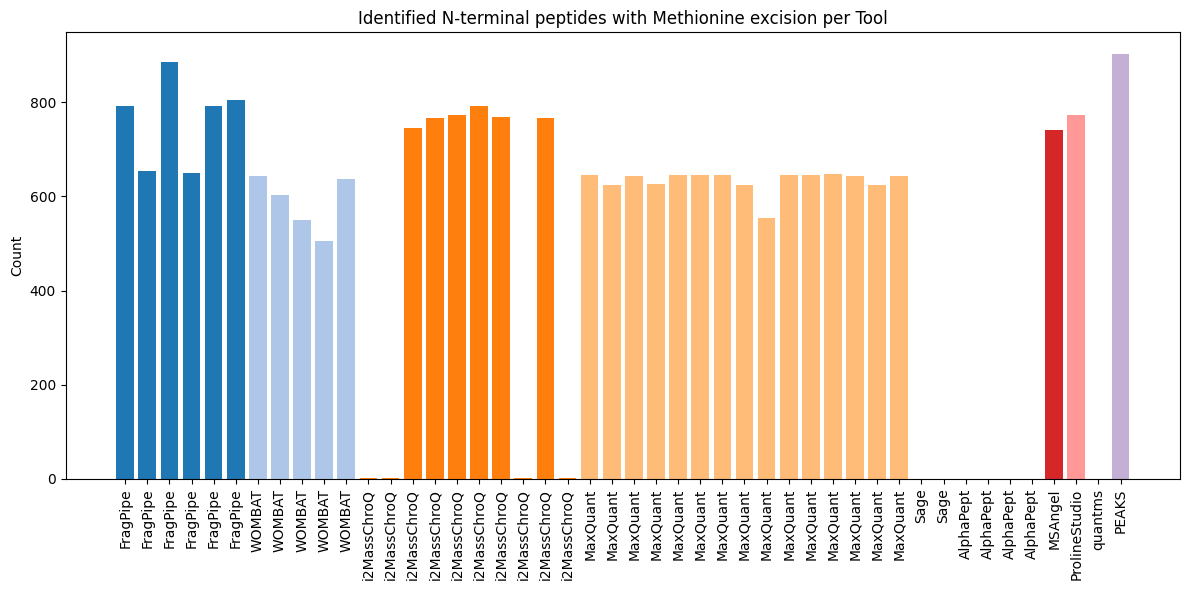

In [41]:
data = {
    'FragPipe': [792, 654, 886, 649, 792, 805],
    'WOMBAT': [643, 602, 550, 506, 636],
    'i2MassChroQ': [1, 1, 746, 766, 773, 791, 768, 1, 766, 1],
    'MaxQuant': [646, 623, 644, 626, 646, 646, 645, 624, 554, 646, 646, 647, 644, 624, 644],
    'Sage': [0, 0],
    'AlphaPept': [0, 0, 0, 0],
    'MSAngel': [741],
    'ProlineStudio': [772],
    'quantms': [0],
    'PEAKS': [903]
}

# Flatten data for plotting
counts = []
colors = []
tool_labels = []
color_map = plt.cm.tab20  # color palette
tool_names = list(data.keys())

for i, tool in enumerate(tool_names):
    vals = data[tool]
    counts.extend(vals)
    colors.extend([color_map(i % 20)] * len(vals))
    tool_labels.extend([tool] * len(vals))

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(counts)), counts, color=colors)

# Label x-axis with tool names, repeated for each bar
plt.xticks(range(len(counts)), tool_labels, rotation=90)

plt.ylabel("Count")
plt.title("Identified N-terminal peptides with Methionine excision per Tool")
plt.tight_layout()
plt.show()